In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ztest


In [3]:
from world import World
from grid_data import Rainfall, SurfaceTemperature
from utils import movmean

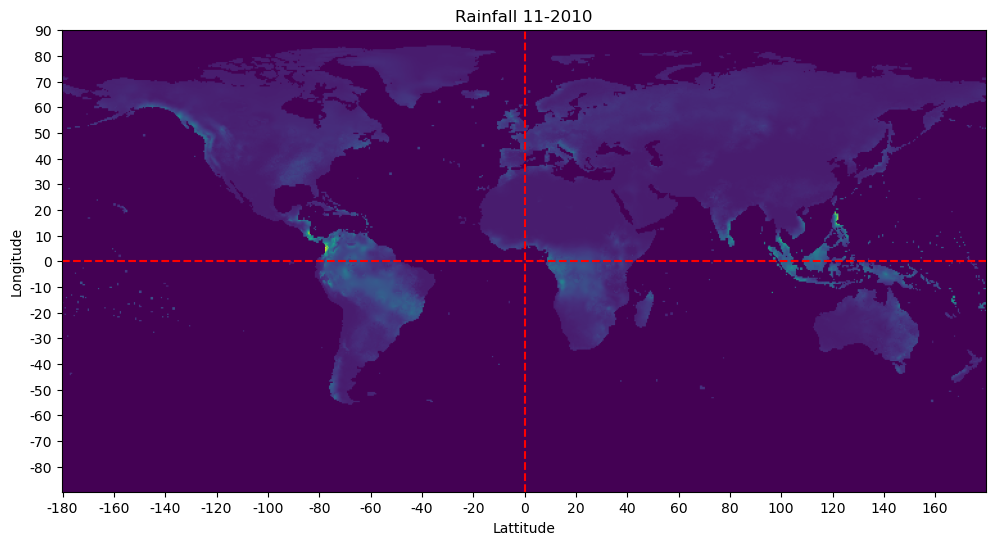

In [4]:
# fetch data
rainfall = Rainfall()
rainfall.fetch_data_years(1901, 2023, delete_file=True)

# get 2001 january for the entire world and plot
ax = rainfall.plot_month(11, 2010)
plt.show()

# Create the world object and create lookup array

In [5]:
# create the world object
world = World('tests/aux_files/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
world.create_lookup()

In [6]:
world.iso_to_idx.keys()

dict_keys(['ATA', 'CHL', 'ARG', 'GB1', 'FR1', 'NZ1', 'AU1', 'URY', 'ZAF', 'BRA', 'LSO', 'NAM', 'PRY', 'SWZ', 'BWA', 'MOZ', 'MDG', 'BOL', 'ZWE', 'PER', 'FJI', 'AGO', 'ZMB', 'MWI', 'VUT', 'COD', 'TZA', 'PNG', 'SLB', 'IDN', 'TLS', 'ECU', 'COG', 'KEN', 'COL', 'BDI', 'GAB', 'RWA', 'SOM', 'UGA', 'VEN', 'MYS', 'GUY', 'GNQ', 'SUR', 'CMR', 'CAF', 'ETH', 'SDS', 'LBR', 'CIV', 'NGA', 'BRN', 'GHA', 'THA', 'PHL', 'TGO', 'BEN', 'LKA', 'SLE', 'PAN', 'GIN', 'TCD', 'SOL', 'CRI', 'IND', 'SDN', 'VNM', 'BFA', 'TTO', 'MLI', 'MMR', 'NIC', 'KHM', 'GNB', 'DJI', 'NER', 'SEN', 'ERI', 'YEM', 'SLV', 'HND', 'GMB', 'GTM', 'LAO', 'MEX', 'MRT', 'BLZ', 'SAU', 'OMN', 'JAM', 'DOM', 'US1', 'HTI', 'CH1', 'DZA', 'CU1', 'LBY', 'MAR', 'SAH', 'BGD', 'EGY', 'ARE', 'TWN', 'PAK', 'BHS', 'QAT', 'IRN', 'NPL', 'BTN', 'KWT', 'JOR', 'IRQ', 'AFG', 'IS1', 'TUN', 'JPN', 'SYR', 'LBN', 'KOR', 'GRC', 'CYP', 'TKM', 'ESP', 'TUR', 'PRT', 'ITA', 'TJK', 'UZB', 'PRK', 'AZE', 'ARM', 'KGZ', 'ALB', 'MKD', 'KA1', 'BGR', 'GEO', 'RUS', 'CAN', 'MNG', 'M

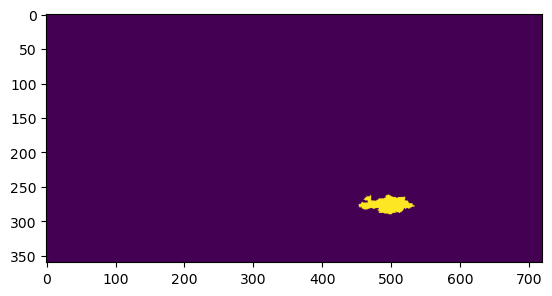

In [7]:
test = np.copy(world.world_array)
idx = world.iso_to_idx['KA1']
test[np.where(test != idx)] = -99999
plt.imshow(test)

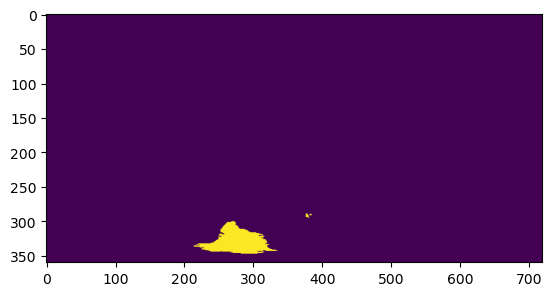

In [8]:
test = np.copy(world.world_array)
idx = world.iso_to_idx['DN1']
test[np.where(test != idx)] = -99999
plt.imshow(test)

In [9]:
iso_change = {'GB1': 'GBR',
              'FR1': 'FRA',
              'NZ1': 'NZL',
              'AU1': 'AUS',
              'US1': 'USA',
              'CH1': 'CHE', # switzerland?
              'CU1': 'CUB',
              'IS1': 'ISL', # iceland
              'KA1': 'KAZ', #??
              'NL1': 'NLD',
              'DN1': 'DNK', #??
              'FI1': 'FIN'
              }

world.change_iso_code(iso_change)

### Quick test to see if country selections make sense

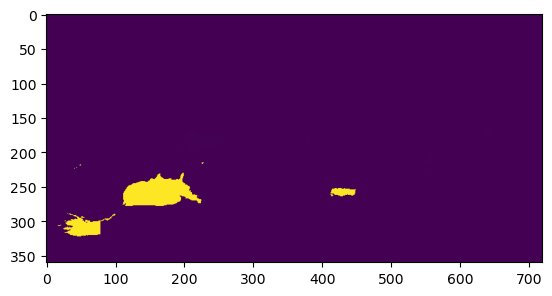

In [10]:
# quick test for selecting country
idx = world.get_grid_points_of_country(iso_code='TUR')
data = np.copy(rainfall.get_month(5, 2007))
data[idx] = 999999
idx = world.get_grid_points_of_country(iso_code='USA')
data[idx] = 999999
plt.imshow(data)
plt.show()

### Plot rainfall totals for Turkey and Syria, just as a test

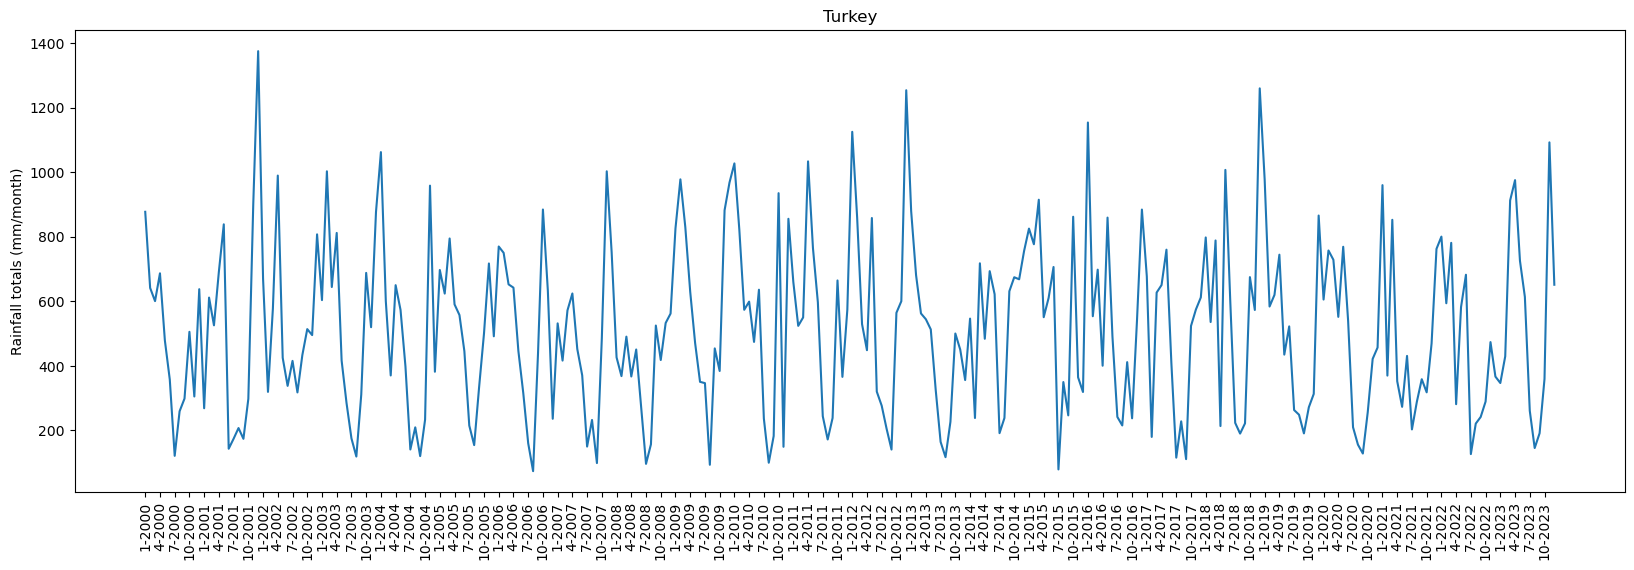

In [11]:
t, dates, totals = rainfall.get_country_avg((1,12), (2000,2023),'TUR', world)
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(t, totals)
ax.set_xticks(t[::3])
ax.set_xticklabels(dates[::3], rotation=90)
ax.set_ylabel('Rainfall totals (mm/month)')
ax.set_title('Turkey')
plt.show()

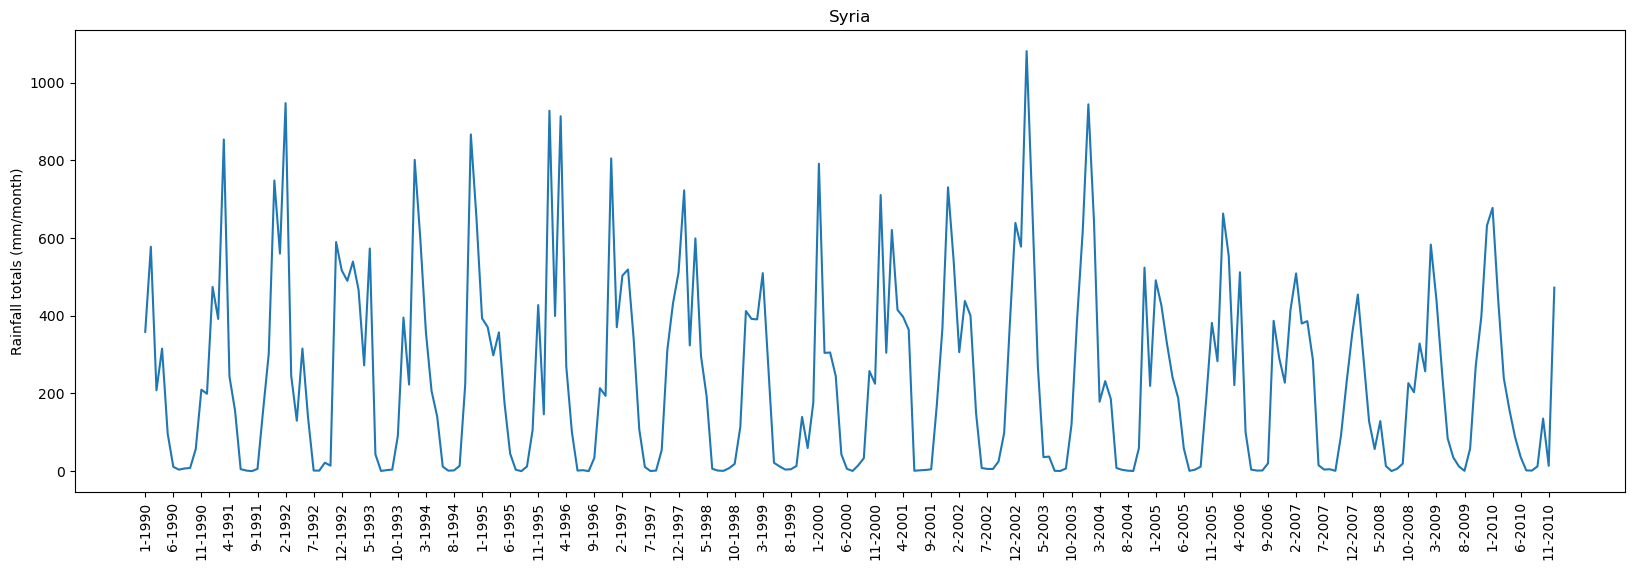

In [12]:
t, dates, totals = rainfall.get_country_avg((1,12), (1990,2010),'SYR', world)
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(t, totals)
ax.set_xticks(t[::5])
ax.set_xticklabels(dates[::5], rotation=90)
ax.set_ylabel('Rainfall totals (mm/month)')
ax.set_title('Syria')
plt.show()

### Syria 6-month winter averages (November-April) as plotted in Fig.1 of [Kelley et al.](https://www.pnas.org/doi/epdf/10.1073/pnas.1421533112)

The orange line is a moving average with a window of 50 years, meant to depict the overall decrease trend starting around ~1990.

p-value for pre 1930s temperature to be larger is 0.07485028305619477, with a test statistic of 1.4405899331246053.


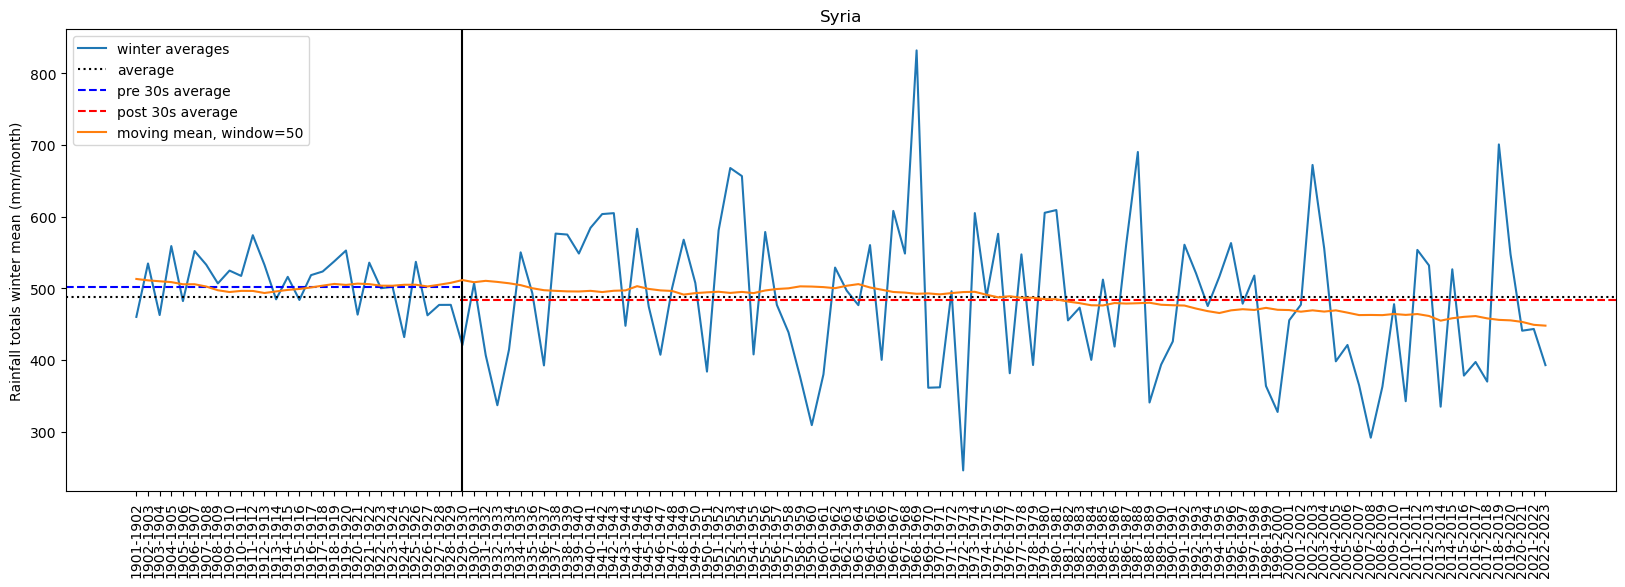

In [13]:
t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'SYR', world)

# quick hypothesis testing with H_0: mu_1=mu_2, H_a: mu_2>mu_1
pre_30s = winter_means[:31]
post_30s = winter_means[31:]
pop_mean_diff = np.mean(post_30s)-np.mean(pre_30s)
z, p = ztest(x1=pre_30s, x2=post_30s, alternative='larger', usevar='unequal')
print(f"p-value for pre 1930s temperature to be larger is {p}, with a test statistic of {z}.")

fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(t, winter_means, label='winter averages')
ax.axhline(np.mean(winter_means), color='k', linestyle='dotted', label='average')
ax.axhline(np.mean(winter_means[:31]), color='b', linestyle='dashed', xmax=31/len(dates), label='pre 30s average')
ax.axhline(np.mean(winter_means[31:]), color='r', linestyle='dashed', xmin=31/len(dates), label='post 30s average')
ax.axvline(28, color='k')
ax.plot(t, movmean(winter_means, window=50), label='moving mean, window=50')

ax.set_xticks(t)
ax.set_xticklabels(dates, rotation=90)
ax.set_ylabel('Rainfall totals winter mean (mm/month)')
ax.set_title('Syria')
ax.legend()
plt.show()

Try different cutoffs for the year for the z-test. (This is probably p-hacking)

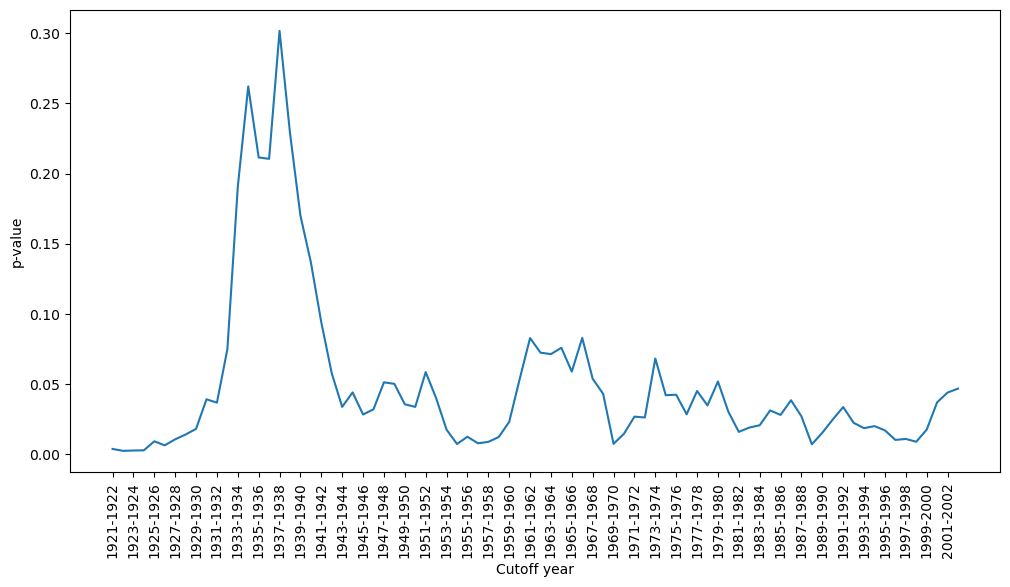

In [14]:
cutoffs = []
pvals = []
margin = 20
for i in range(margin,len(winter_means)-margin):
    pre = winter_means[:i]
    post = winter_means[i:]
    z, p = ztest(x1=pre, x2=post, alternative='larger', usevar='unequal')
    cutoffs.append(i)
    pvals.append(p)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(cutoffs, pvals)
ax.set_xlabel('Cutoff year')
ax.set_ylabel('p-value')
ax.set_xticks(cutoffs[::2])
ax.set_xticklabels(dates[margin:-margin][::2], rotation=90)
plt.show()

Same for Turkey, just out of curiosity. Note that a similar trend exists, but the total rainfall is an order of magnitude larger. This suggests to me that maybe if the total rainfall is large enough, the economical impacts of a drought may be more robust to rainfall variation. 

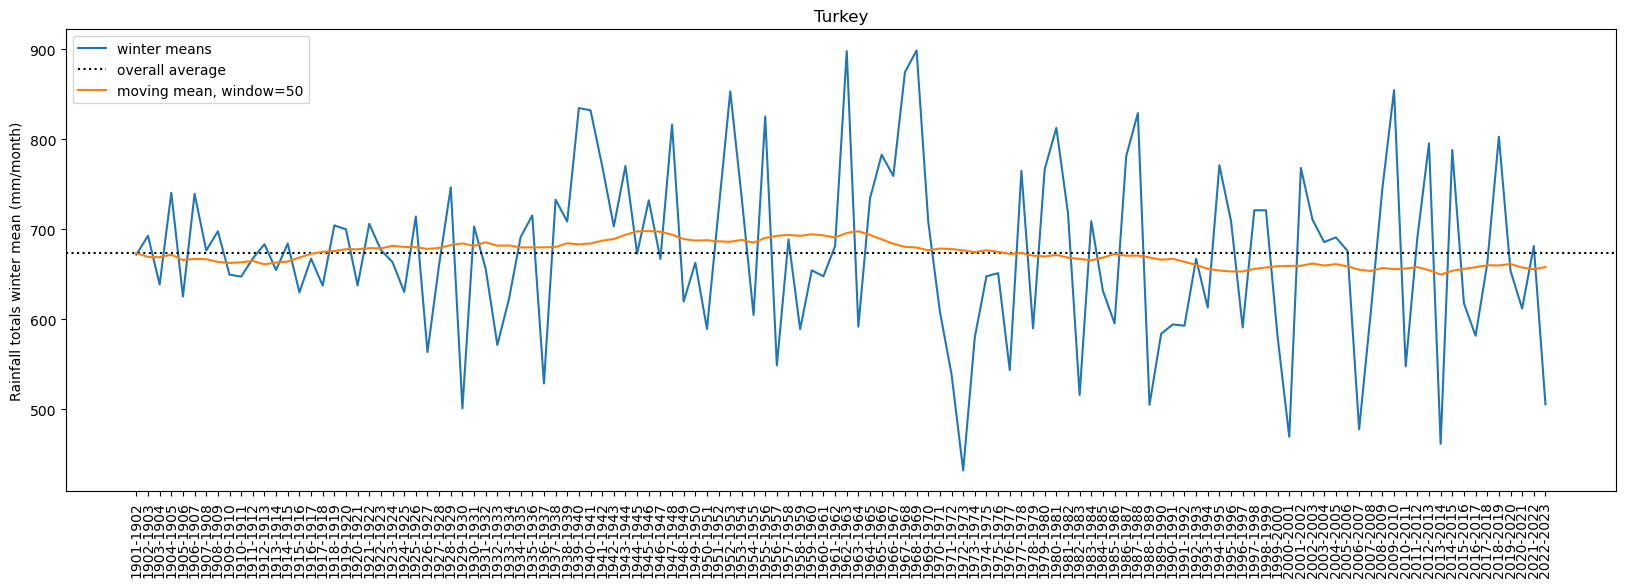

In [15]:
t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'TUR', world)
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(t, winter_means, label='winter means')
ax.axhline(np.mean(winter_means), color='k', linestyle='dotted', label='overall average')
ax.plot(t, movmean(winter_means, window=50), label='moving mean, window=50')
ax.set_xticks(t)
ax.set_xticklabels(dates, rotation=90)
ax.set_ylabel('Rainfall totals winter mean (mm/month)')
ax.set_title('Turkey')
ax.legend()
plt.show()

Rainfall variation (as numerical differentiation)

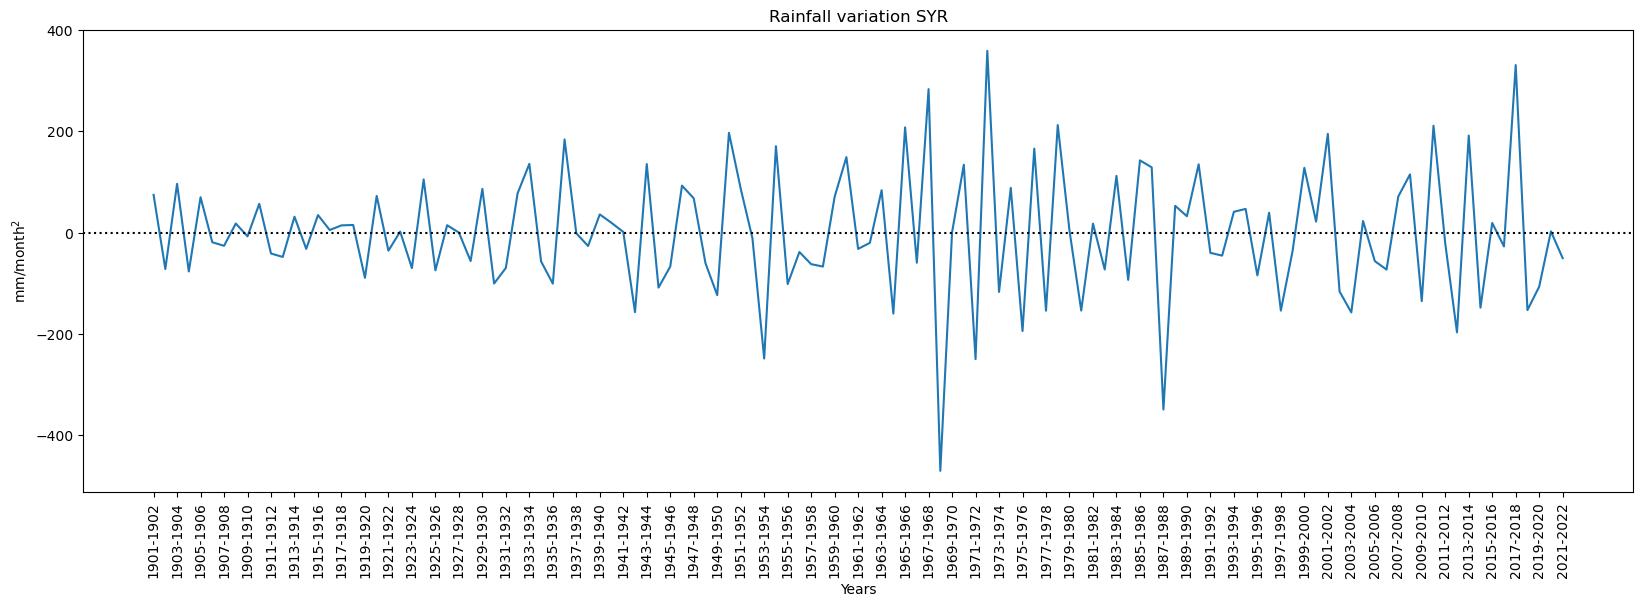

In [16]:
t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'SYR', world)
variation = np.diff(winter_means)
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(t[:-1], variation)
ax.set_xticks(t[::2])
ax.set_xticklabels(dates[::2], rotation=90)
ax.axhline(0, color='k', linestyle='dotted')
ax.set_title('Rainfall variation SYR')
ax.set_xlabel('Years')
ax.set_ylabel('mm/month$^2$')
plt.show()

## Compare with GDP

In [17]:
df = pd.read_csv("https://ourworldindata.org/grapher/gdp-worldbank-constant-usd.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})
df.head(5)

Entity Code  Year  ny_gdp_mktp_kd
0  Afghanistan  AFG  2000    6.206548e+09
1  Afghanistan  AFG  2001    5.621148e+09
2  Afghanistan  AFG  2002    7.228796e+09
3  Afghanistan  AFG  2003    7.867264e+09
4  Afghanistan  AFG  2004    7.978516e+09

In [18]:
df['Code'].unique()

array(['AFG', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'ATG', 'ARG', 'ARM',
       'ABW', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR',
       'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BIH', 'BWA', 'BRA',
       'BRN', 'BGR', 'BFA', 'BDI', 'KHM', 'CMR', 'CAN', 'CPV', 'CYM',
       'CAF', 'TCD', 'OWID_CIS', 'CHL', 'CHN', 'COL', 'COM', 'COG', 'CRI',
       'CIV', 'HRV', 'CUB', 'CUW', 'CYP', 'CZE', 'COD', 'DNK', 'DJI',
       'DMA', 'DOM', nan, 'TLS', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST',
       'SWZ', 'ETH', 'FJI', 'FIN', 'FRA', 'PYF', 'GAB', 'GMB', 'GEO',
       'DEU', 'GHA', 'GRC', 'GRL', 'GRD', 'GUM', 'GTM', 'GIN', 'GNB',
       'GUY', 'HTI', 'HND', 'HKG', 'HUN', 'ISL', 'IND', 'IDN', 'IRN',
       'IRQ', 'IRL', 'IMN', 'ISR', 'ITA', 'JAM', 'JPN', 'JOR', 'KAZ',
       'KEN', 'KIR', 'OWID_KOS', 'KWT', 'KGZ', 'LAO', 'LVA', 'LBN', 'LSO',
       'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MAC', 'MDG', 'MWI', 'MYS',
       'MDV', 'MLI', 'MLT', 'MHL', 'MRT', 'MUS', 'MEX', 'FSM', 'MDA',
     

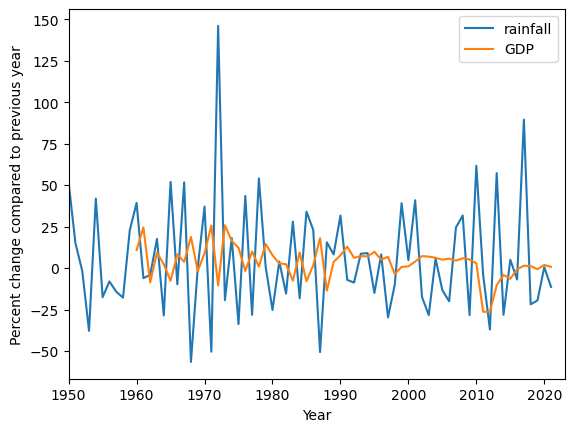

In [19]:
year = df[df['Code'] == 'SYR'].Year

gdp = df[df['Code'] == 'SYR'].ny_gdp_mktp_kd
gdp_var = 100*np.diff(gdp)/gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'SYR', world)
variation = 100*np.diff(winter_means)/winter_means[:-1]
tx = np.arange(1901, 2022) 

plt.plot(tx, variation, label='rainfall')
plt.plot(year[:-1], gdp_var, label='GDP')
plt.xlabel('Year')
plt.ylabel('Percent change compared to previous year')
plt.xlim(1950,2023)
plt.legend()
plt.show()

OLS attempt at rainfall variation and change in GDP for Syria

[[0.         0.03477456]] 0.015191192251121977


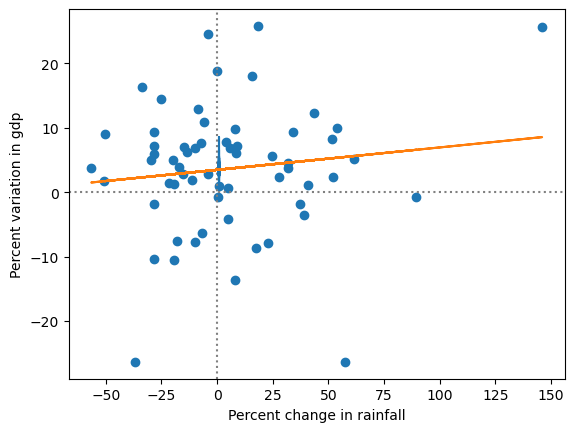

In [20]:
from sklearn.linear_model import LinearRegression

year = df[df['Code'] == 'SYR'].Year

gdp = df[df['Code'] == 'SYR'].ny_gdp_mktp_kd
gdp_var = 100*np.diff(gdp)/gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1960,2023), 'SYR', world)
variation = 100*np.diff(winter_means)/winter_means[:-1]
tx = np.arange(1961, 2022)

plt.scatter(variation[1:], gdp_var[:-1])
plt.xlabel('Percent change in rainfall')
plt.ylabel('Percent variation in gdp')
plt.axhline(0, color='gray', linestyle='dotted')
plt.axvline(0, color='gray', linestyle='dotted')

X = np.hstack((np.ones((len(variation[1:]), 1)), variation[1:].reshape(-1, 1)))
y = gdp_var[:-1].to_numpy().reshape(-1, 1)
reg = LinearRegression().fit(X, y)
print(reg.coef_, reg.score(X, y))
plt.plot(X, reg.predict(X))
plt.show()

Same, but not normalized

[[     0.         603848.45102385]] 0.002775611096733299


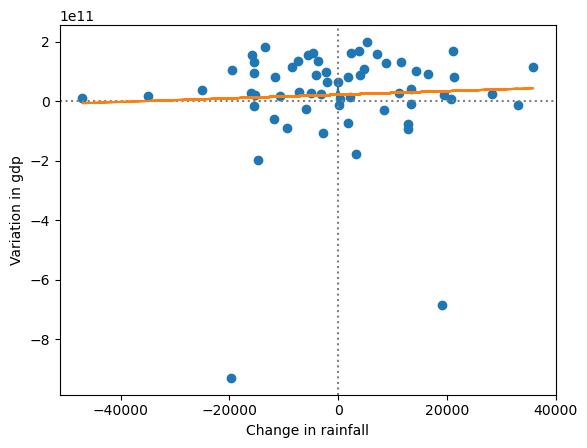

In [21]:
year = df[df['Code'] == 'SYR'].Year

gdp = df[df['Code'] == 'SYR'].ny_gdp_mktp_kd
gdp_var = 100*np.diff(gdp)

t, dates, winter_means = rainfall.get_country_winter_mean((1960,2023), 'SYR', world)
variation = 100*np.diff(winter_means)

plt.scatter(variation[1:], gdp_var[:-1])
plt.xlabel('Change in rainfall')
plt.ylabel('Variation in gdp')
plt.axhline(0, color='gray', linestyle='dotted')
plt.axvline(0, color='gray', linestyle='dotted')

X = np.hstack((np.ones((len(variation[1:]), 1)), variation[1:].reshape(-1, 1)))
y = gdp_var[:-1].reshape(-1, 1)
reg = LinearRegression().fit(X, y)
print(reg.coef_, reg.score(X, y))
plt.plot(X, reg.predict(X))
plt.show()

Plotting rainfall variation and change in GDP for Turkey

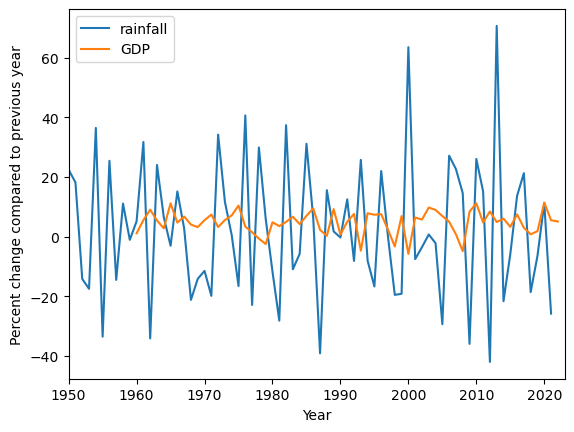

In [22]:
year = df[df['Code'] == 'TUR'].Year

gdp = df[df['Code'] == 'TUR'].ny_gdp_mktp_kd
gdp_var = 100*np.diff(gdp)/gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'TUR', world)
variation = 100*np.diff(winter_means)/winter_means[:-1]
tx = np.arange(1901, 2022)

plt.plot(tx, variation, label='rainfall')
plt.plot(year[:-1], gdp_var, label='GDP')
plt.xlabel('Year')
plt.ylabel('Percent change compared to previous year')
plt.xlim(1950,2023)
plt.legend()
plt.show()

## Function to calculate variations as described in [Miguel et al. 2004](http://emiguel.econ.berkeley.edu/wordpress/wp-content/uploads/2021/03/Paper__Economic_Shocks_and_Civil_Conflict.pdf):

For rainfall $R$, the variation is
$$
\Delta R_{it} = \frac{R_{it}-R_{i,t-1}}{R_{i,t-1}},
$$
where $i$ denotes the country and $t$ denotes the year.

In [23]:
from utils import diff

# Basic OLS attempts

In [24]:
# design matrix roughly following the rainfall paper

year = df[df['Code'] == 'SYR'].Year
gdp = df[df['Code'] == 'SYR'].ny_gdp_mktp_kd

t, dates, winter_means = rainfall.get_country_winter_mean((1960,2023), 'SYR', world)

r_it = diff(winter_means)
r_it_1 = diff(winter_means, lag=1)


X = np.hstack((np.ones((len(r_it_1), 1)), r_it[1:].reshape(-1, 1)))
X = np.hstack((X, r_it_1.reshape(-1, 1)))
X = np.hstack((X, year[2:].to_numpy().reshape(-1, 1)))

gdp_var = diff(gdp)
y = gdp_var[1:].reshape(-1, 1)

reg = LinearRegression().fit(X, y)
print(reg.coef_, reg.score(X, y))

[[ 0.         -0.05400169  0.08884867 -0.00192038]] 0.3197112384553029


In [25]:
# design matrix roughly following the rainfall paper

year = df[df['Code'] == 'TUR'].Year
year = year[:-1]

gdp = df[df['Code'] == 'TUR'].ny_gdp_mktp_kd
gdp = gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1960,2023), 'TUR', world)

r_it = diff(winter_means)
r_it_1 = diff(winter_means, lag=1)


X = np.hstack((np.ones((len(r_it_1), 1)), r_it[1:].reshape(-1, 1)))
X = np.hstack((X, r_it_1.reshape(-1, 1)))
X = np.hstack((X, year[2:].to_numpy().reshape(-1, 1)))

gdp_var = diff(gdp)
y = gdp_var[1:].reshape(-1, 1)

reg = LinearRegression().fit(X, y)
print(reg.coef_, reg.score(X, y))


[[ 0.00000000e+00 -4.64031449e-02 -9.74145575e-03 -7.12975849e-05]] 0.0696873396629395


In [26]:
year = df[df['Code'] == 'RWA'].Year
year = year[:-1]

gdp = df[df['Code'] == 'RWA'].ny_gdp_mktp_kd
gdp = gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1960,2023), 'RWA', world)

r_it = diff(winter_means)
r_it_1 = diff(winter_means, lag=1)


X = np.hstack((np.ones((len(r_it_1), 1)), r_it[1:].reshape(-1, 1)))
X = np.hstack((X, r_it_1.reshape(-1, 1)))
X = np.hstack((X, year[2:].to_numpy().reshape(-1, 1)))

gdp_var = diff(gdp)
y = gdp_var[1:].reshape(-1, 1)

reg = LinearRegression().fit(X, y)
print(reg.coef_, reg.score(X, y))


[[ 0.          0.01435919 -0.01330404  0.00079599]] 0.02471973145890427


In [27]:
year = df[df['Code'] == 'TZA'].Year
year = year[:-1]

gdp = df[df['Code'] == 'TZA'].ny_gdp_mktp_kd
gdp = gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1960,2023), 'TZA', world)

r_it = diff(winter_means)
r_it_1 = diff(winter_means, lag=1)


X = np.hstack((np.ones((len(r_it_1), 1)), r_it[1:].reshape(-1, 1)))
X = np.hstack((X, r_it_1.reshape(-1, 1)))
X = np.hstack((X, year[2:].to_numpy().reshape(-1, 1)))

gdp_var = diff(gdp)
y = gdp_var[1:].reshape(-1, 1)

reg = LinearRegression().fit(X, y)
print(reg.coef_, reg.score(X, y))


[[0.         0.02506661 0.01809996 0.00082745]] 0.04922830434691261


# Join multiple datasets

- Annual GDP data
- Annual winter rainfall data
- Share of GDP from agriculture
- Oil rents as a share of GDP
- Democracy index Polity V
- Ethnic fractionalization index

In [28]:
from csv_fetcher import CsvFetcher

In [29]:
fetcher = CsvFetcher('https://ourworldindata.org/grapher/agriculture-share-gdp.csv?v=1&csvType=full&useColumnShortNames=true')
agricultural_share = fetcher.fetch()
agricultural_share.head(5)

iso_name = agricultural_share.copy()
iso_name = iso_name[['Entity', 'Code']].drop_duplicates(ignore_index=True)

In [30]:
agricultural_share[agricultural_share.isna().any(axis=1)]

# remove region info
agricultural_share.dropna(inplace=True)


In [31]:
iso_name

Entity      Code
0    Afghanistan       AFG
1        Albania       ALB
2        Algeria       DZA
3        Andorra       AND
4         Angola       AGO
..           ...       ...
215      Vietnam       VNM
216        World  OWID_WRL
217        Yemen       YEM
218       Zambia       ZMB
219     Zimbabwe       ZWE

[220 rows x 2 columns]

In [32]:
print(agricultural_share['Code'].unique(), agricultural_share['Code'].nunique())

['AFG' 'ALB' 'DZA' 'AND' 'AGO' 'ATG' 'ARG' 'ARM' 'ABW' 'AUS' 'AUT' 'AZE'
 'BHS' 'BHR' 'BGD' 'BRB' 'BLR' 'BEL' 'BLZ' 'BEN' 'BMU' 'BTN' 'BOL' 'BIH'
 'BWA' 'BRA' 'BRN' 'BGR' 'BFA' 'BDI' 'KHM' 'CMR' 'CAN' 'CPV' 'CYM' 'CAF'
 'TCD' 'OWID_CIS' 'CHL' 'CHN' 'COL' 'COM' 'COG' 'CRI' 'CIV' 'HRV' 'CUB'
 'CUW' 'CYP' 'CZE' 'COD' 'DNK' 'DJI' 'DMA' 'DOM' 'TLS' 'ECU' 'EGY' 'SLV'
 'GNQ' 'ERI' 'EST' 'SWZ' 'ETH' 'FJI' 'FIN' 'FRA' 'PYF' 'GAB' 'GMB' 'GEO'
 'DEU' 'GHA' 'GRC' 'GRL' 'GRD' 'GTM' 'GIN' 'GNB' 'GUY' 'HTI' 'HND' 'HKG'
 'HUN' 'ISL' 'IND' 'IDN' 'IRN' 'IRQ' 'IRL' 'IMN' 'ISR' 'ITA' 'JAM' 'JPN'
 'JOR' 'KAZ' 'KEN' 'KIR' 'OWID_KOS' 'KWT' 'KGZ' 'LAO' 'LVA' 'LBN' 'LSO'
 'LBR' 'LBY' 'LIE' 'LTU' 'LUX' 'MDG' 'MWI' 'MYS' 'MDV' 'MLI' 'MLT' 'MHL'
 'MRT' 'MUS' 'MEX' 'FSM' 'MDA' 'MNG' 'MNE' 'MAR' 'MOZ' 'MMR' 'NAM' 'NPL'
 'NLD' 'NCL' 'NZL' 'NIC' 'NER' 'NGA' 'MKD' 'NOR' 'OMN' 'PAK' 'PLW' 'PSE'
 'PAN' 'PNG' 'PRY' 'PER' 'PHL' 'POL' 'PRT' 'PRI' 'QAT' 'ROU' 'RUS' 'RWA'
 'KNA' 'LCA' 'VCT' 'WSM' 'SMR' 'STP' 'SAU' 'SEN' 'SRB

In [33]:
from missing_value_handler import add_missing_years, fill_na

In [34]:
agricultural_share = add_missing_years(agricultural_share,
                                       min_year=1960,
                                       max_year=2023,
                                       year_name='Year',
                                       ref_column='Code')

In [35]:
agricultural_share[agricultural_share['Code']=='AFG']
agricultural_share = agricultural_share.drop('Entity', axis=1)

In [36]:
fill_na(agricultural_share, 'nv_agr_totl_zs', 'Code', 'AFG', method='max')
agricultural_share[agricultural_share['Code']=='AFG']

Code  Year  nv_agr_totl_zs
0   AFG  2002       38.627890
1   AFG  2003       37.418854
2   AFG  2004       29.721067
3   AFG  2005       31.114855
4   AFG  2006       28.635970
..  ...   ...             ...
0   AFG  1997       38.627890
0   AFG  1998       38.627890
0   AFG  1999       38.627890
0   AFG  2000       38.627890
0   AFG  2001       38.627890

[64 rows x 3 columns]

In [37]:
# do the same to all the other countries
for country in agricultural_share['Code'].unique():
    fill_na(agricultural_share, 'nv_agr_totl_zs', 'Code', country, method='max')

agricultural_share = agricultural_share.sort_values(by=['Code','Year'])

In [38]:
agricultural_share.sample(10)

Code  Year  nv_agr_totl_zs
1925  HRV  2015        2.963466
698   BEN  1992       33.941906
2863  FJI  1994       17.918290
6167  MKD  2021        7.147489
3804  ISL  2017        3.778000
0     ARE  1965        2.333245
3541  GUY  1963       24.460670
0     TLS  1989       32.204285
8726  UGA  2003       24.507023
0     PLW  1966        4.721352

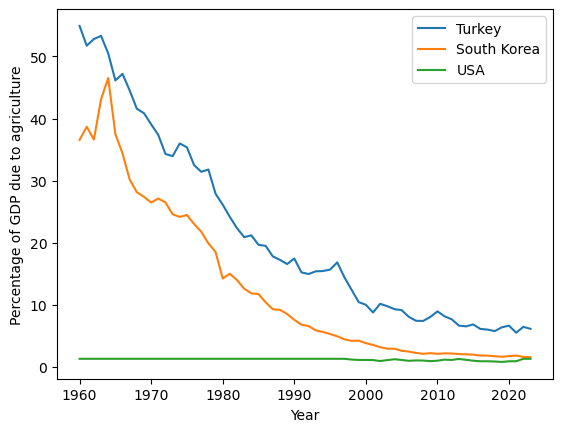

In [39]:
test = agricultural_share[agricultural_share['Code']=='TUR']
plt.plot(test['Year'], test['nv_agr_totl_zs'], label='Turkey')

test = agricultural_share[agricultural_share['Code']=='KOR']
plt.plot(test['Year'], test['nv_agr_totl_zs'], label='South Korea')

test = agricultural_share[agricultural_share['Code']=='USA']
plt.plot(test['Year'], test['nv_agr_totl_zs'], label='USA')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Percentage of GDP due to agriculture')
plt.show()

In [40]:
fetcher = CsvFetcher('https://ourworldindata.org/grapher/oil-rents-as-a-share-of-gdp.csv?v=1&csvType=full&useColumnShortNames=true')
oil_rent = fetcher.fetch()
oil_rent = oil_rent.drop('Entity', axis=1)
oil_rent = oil_rent.dropna()
oil_rent = add_missing_years(oil_rent,
                             min_year=1960,
                             max_year=2023,
                             year_name='Year',
                             ref_column='Code')

for country in oil_rent['Code'].unique():
    fill_na(oil_rent, 'ny_gdp_petr_rt_zs', 'Code', country, method='min')

oil_rent = oil_rent.sort_values(by=['Code', 'Year'])
oil_rent.reset_index(drop=True, inplace=True)

oil_rent.sample(10)

Code  Year  ny_gdp_petr_rt_zs
7420   MEX  2020           0.867385
9955   SAU  1995          28.127033
5116   HTI  2020           0.000000
3488   EGY  1992          11.122130
8454   NLD  1966           0.003729
6953   LUX  2001           0.000000
11007  SYC  2023           0.000000
11671  TUN  1983          11.635751
5919   KAZ  1991           6.662536
498    ASM  2010           0.000000

In [41]:
oil_rent[oil_rent.isna().any(axis=1)]

Empty DataFrame
Columns: [Code, Year, ny_gdp_petr_rt_zs]
Index: []

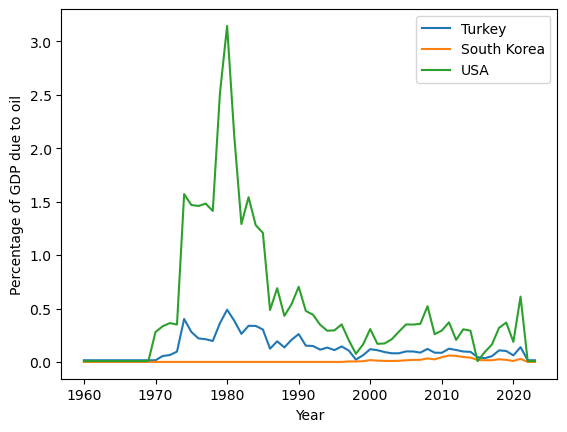

In [42]:
test = oil_rent[oil_rent['Code']=='TUR']
plt.plot(test['Year'], test['ny_gdp_petr_rt_zs'], label='Turkey')

test = oil_rent[oil_rent['Code']=='KOR']
plt.plot(test['Year'], test['ny_gdp_petr_rt_zs'], label='South Korea')

test = oil_rent[oil_rent['Code']=='USA']
plt.plot(test['Year'], test['ny_gdp_petr_rt_zs'], label='USA')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Percentage of GDP due to oil') # is this true?
plt.show()

In [43]:
fetcher = CsvFetcher('https://ourworldindata.org/grapher/democracy-index-polity.csv?v=1&csvType=full&useColumnShortNames=true')
democracy_index = fetcher.fetch()
democracy_index = democracy_index.drop('Entity', axis=1)
democracy_index = add_missing_years(democracy_index,
                                    min_year=1960,
                                    max_year=2023,
                                    year_name='Year',
                                    ref_column='Code')

for country in democracy_index['Code'].unique():
    fill_na(democracy_index, 'democracy_polity', 'Code', country, method='mean')

democracy_index = democracy_index.sort_values(by=['Code','Year'])

democracy_index.head(5)

Code  Year  democracy_polity
0  AFG  1800              -6.0
1  AFG  1801              -6.0
2  AFG  1802              -6.0
3  AFG  1803              -6.0
4  AFG  1804              -6.0

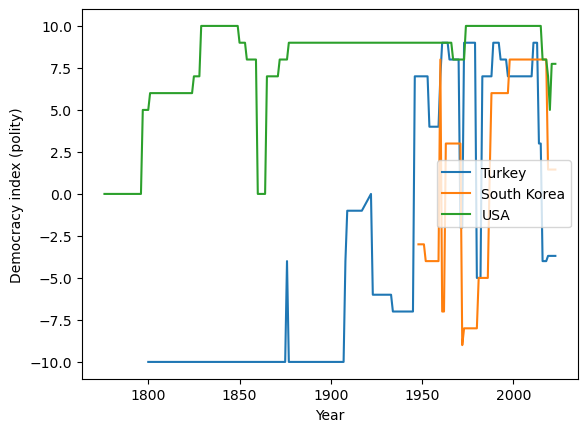

In [44]:
test = democracy_index[democracy_index['Code'] == 'TUR']
plt.plot(test['Year'], test['democracy_polity'], label='Turkey')

test = democracy_index[democracy_index['Code'] == 'KOR']
plt.plot(test['Year'], test['democracy_polity'], label='South Korea')

test = democracy_index[democracy_index['Code'] == 'USA']
plt.plot(test['Year'], test['democracy_polity'], label='USA')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Democracy index (polity)')
plt.show()

In [45]:
fetcher = CsvFetcher('https://cadmus.eui.eu/bitstream/handle/1814/64606/Historical_Index_of_Ethnic_Fractionalisation_Dataset.csv?sequence=3&isAllowed=y')
ethnic_fractionation = fetcher.fetch()
ethnic_fractionation = add_missing_years(ethnic_fractionation,
                                         min_year=1960,
                                         max_year=2023,
                                         year_name='Year',
                                         ref_column='Country')

for country in ethnic_fractionation['Country'].unique():
    fill_na(ethnic_fractionation, 'EFindex', 'Country', country, method='max')

ethnic_fractionation = ethnic_fractionation.sort_values(by=['Country', 'Year'])
ethnic_fractionation.rename(columns={'Country':'Entity'}, inplace=True)
ethnic_fractionation.sample(10)

Entity  Year  EFindex
8584         East Timor  2008    0.846
6523            Lebanon  2012    0.133
0       Kyrgyz Republic  1962    0.652
2510       Burkina Faso  1963    0.734
2253              Benin  1978    0.785
0               Senegal  2021    0.803
0     Republic of Korea  2022    0.095
1833            Belarus  2009    0.318
7125        Afghanistan  1992    0.706
0                Zambia  2017    0.804

In [46]:
print(iso_name.Entity.to_list())

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Cayman Islands', 'Central African Republic', 'Chad', 'Channel Islands', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'East Asia and Pacific (WB)', 'East Timor', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Europe and Central Asia (WB)', 'European Union (27)', 'Faeroe Islands', 'Fiji', 'Finland', 'France', 'French Polynesia', 'Gabon', 'Gambia', 

In [47]:
set_name = set(iso_name.Entity.to_list())
set_ethnic_name = set(ethnic_fractionation.Entity.to_list())
print(set_name.difference(set_ethnic_name))
print(set_ethnic_name.difference(set_name))

{'Cameroon', 'Latin America and Caribbean (WB)', 'Palau', 'Seychelles', 'Bahamas', 'Palestine', 'Samoa', 'Iceland', 'East Asia and Pacific (WB)', 'San Marino', 'Antigua and Barbuda', 'Kosovo', 'New Caledonia', 'Liechtenstein', 'Maldives', 'Kyrgyzstan', 'Faeroe Islands', 'Turks and Caicos Islands', 'France', 'Bosnia and Herzegovina', 'North Macedonia', 'India', 'Cayman Islands', 'Germany', 'Barbados', 'World', 'South Korea', 'Curacao', 'Dominica', 'Sao Tome and Principe', 'Brunei', 'Vanuatu', 'Saint Kitts and Nevis', 'Middle-income countries', 'United States', 'Europe and Central Asia (WB)', 'Bermuda', 'Micronesia (country)', 'Puerto Rico', 'Middle East and North Africa (WB)', 'Vietnam', 'Grenada', 'Papua New Guinea', 'Andorra', 'Montenegro', 'South Asia (WB)', 'Belize', 'Malta', 'Sub-Saharan Africa (WB)', 'Saint Lucia', 'North America (WB)', 'Eswatini', 'Upper-middle-income countries', 'High-income countries', 'Greenland', 'Tuvalu', 'Sint Maarten (Dutch part)', 'Yemen', 'Suriname', 'To

In [48]:
iso_name.replace('South Korea', 'Republic of Korea', inplace=True)
iso_name.replace('United States', 'United States of America', inplace=True)


In [49]:
from fetch_rainfall import fetch_rainfall
temps_to_add = fetch_rainfall(iso_name.Entity, iso_name.Code)
temps_to_add.sample(5)

Error downloading file: 404 Client Error: Not Found for url: https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.08/crucy.2407032054.v4.08/countries/tmp/crucy.v4.08.1901.2023.Aruba.tmp.per
https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.08/crucy.2407032054.v4.08/countries/tmp/crucy.v4.08.1901.2023.Aruba.tmp.per
Error downloading file: 404 Client Error: Not Found for url: https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.08/crucy.2407032054.v4.08/countries/tmp/crucy.v4.08.1901.2023.Cayman_Islands.tmp.per
https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.08/crucy.2407032054.v4.08/countries/tmp/crucy.v4.08.1901.2023.Cayman_Islands.tmp.per
Error downloading file: 404 Client Error: Not Found for url: https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.08/crucy.2407032054.v4.08/countries/tmp/crucy.v4.08.1901.2023.Channel_Islands.tmp.per
https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.08/crucy.2407032054.v4.08/countries/tmp/crucy.v4.08.1901.2023.Channel_Islands.tmp.per
Error downloading file: 404 Client 

ISO3_code  Year  mean_temp
74        QAT  1975       26.7
53        GTM  1954       23.0
83        HTI  1984       24.6
105       AZE  2006       13.3
110       MMR  2011       23.6

In [50]:
print(ethnic_fractionation['Entity'].unique(), ethnic_fractionation['Entity'].nunique())

['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Argentina' 'Armenia'
 'Australia' 'Austria' 'Azerbaijan' 'Bahrain' 'Bangladesh' 'Belarus'
 'Belgium' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia-Herzegovina' 'Botswana'
 'Brazil' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cambodia' 'Canada'
 'Cape Verde' 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia'
 'Comoros' 'Congo' 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba' 'Cyprus'
 'Czech Republic' 'Czechoslovakia' "Democratic People's Republic of Korea"
 'Democratic Republic of Congo' 'Democratic Republic of Vietnam' 'Denmark'
 'Djibouti' 'Dominican Republic' 'East Timor' 'Ecuador' 'Egypt'
 'El Salvador' 'Eritrea' 'Estonia' 'Ethiopia' 'Fiji' 'Finland' 'Gabon'
 'Gambia' 'Georgia' 'German Democratic Republic' 'German Federal Republic'
 'Ghana' 'Greece' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti'
 'Honduras' 'Hungary' 'Indonesia' 'Iran' 'Iraq' 'Ireland' 'Israel' 'Italy'
 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan' 'Kenya' 'Kuwait'
 'Kyrgyz Republ

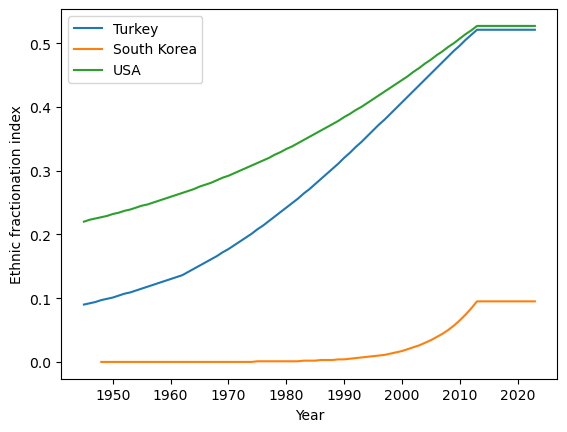

In [51]:
test = ethnic_fractionation[ethnic_fractionation['Entity']=='Turkey']
plt.plot(test['Year'], test['EFindex'], label='Turkey')

test = ethnic_fractionation[ethnic_fractionation['Entity']=='Republic of Korea']
plt.plot(test['Year'], test['EFindex'], label='South Korea')

test = ethnic_fractionation[ethnic_fractionation['Entity']=='United States of America']
plt.plot(test['Year'], test['EFindex'], label='USA')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Ethnic fractionation index')
plt.show()

In [53]:
# our gdp dataset we downloaded above
df = pd.read_csv("https://ourworldindata.org/grapher/gdp-worldbank-constant-usd.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})

df = df.drop('Entity', axis=1)
df = add_missing_years(df, min_year=1960,
                       max_year=2023,
                       year_name='Year',
                       ref_column='Code')

for country in df['Code'].unique():
    fill_na(df, 'ny_gdp_mktp_kd', 'Code', country, method='min')

df = df.sort_values(by=['Code', 'Year'])

df.sample(5)

Code  Year  ny_gdp_mktp_kd
1696   CMR  1974    7.328803e+09
4958   IND  2019    2.689205e+12
1243   BOL  2018    3.736496e+10
11222  UGA  1997    1.045267e+10
9280   WSM  1995    4.520351e+08

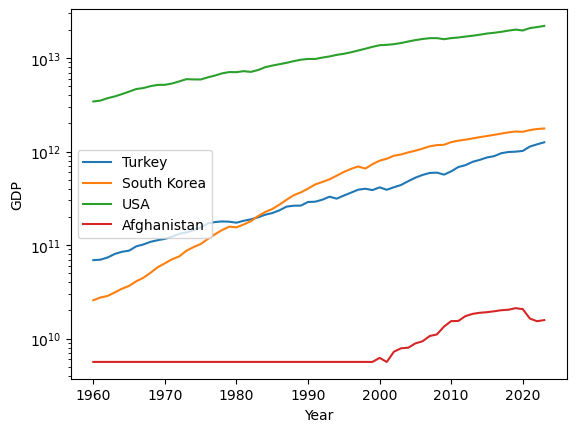

In [54]:
test = df[df['Code']=='TUR']
plt.plot(test['Year'], test['ny_gdp_mktp_kd'], label='Turkey')

test = df[df['Code']=='KOR']
plt.plot(test['Year'], test['ny_gdp_mktp_kd'], label='South Korea')

test = df[df['Code']=='USA']
plt.plot(test['Year'], test['ny_gdp_mktp_kd'], label='USA')

test = df[df['Code']=='AFG']
plt.plot(test['Year'], test['ny_gdp_mktp_kd'], label='Afghanistan')


plt.legend()
plt.xlabel('Year')
plt.ylabel('GDP')
plt.yscale('log')
plt.show()

In [55]:
ethnic_fractionation_with_code = ethnic_fractionation.merge(iso_name, on=['Entity'])
ethnic_fractionation_with_code.sample(10)

Entity  Year  EFindex Code
220                Algeria  2022    0.372  DZA
2961               Ecuador  2006    0.563  ECU
458              Australia  1971    0.038  AUS
8030                Rwanda  2009    0.270  RWA
8953                Sweden  1957    0.112  SWE
143                Albania  2009    0.131  ALB
10006       United Kingdom  2019    0.399  GBR
5088            Kazakhstan  2011    0.556  KAZ
9508   Trinidad and Tobago  2004    0.650  TTO
3527                 Gabon  2000    0.794  GAB

### Finally joining datasets

In [56]:
set1 = set(agricultural_share['Code'].unique())
set2 = set(oil_rent['Code'].unique())
set3 = set(df['Code'].unique())
set4 = set(ethnic_fractionation_with_code['Code'].unique())
set5 = set(world.iso_to_idx.keys())

print("Country codes in agriculture but not in oil rent")
print(set1.difference(set2))
print("Country codes in oil rent but not in agriculture")
print(set2.difference(set1))
print("Country codes in the gdp set but not in world")
print(set3.difference(set5))
print("Country codes in world but not in gdp")
print(set5.difference(set3))
print("Country code in ethnic but not in gdp")
print(set4.difference(set5))
print("Country code in gdp but not in ethnic")
print(set5.difference(set4))



Country codes in agriculture but not in oil rent
{'OWID_CIS', 'MHL', 'IMN', 'SXM', 'PLW', 'LIE', 'CUW', 'AND', 'FSM', 'SMR', 'TUV'}
Country codes in oil rent but not in agriculture
{'ASM', 'VIR', 'NRU', 'GUM', 'MAC'}
Country codes in the gdp set but not in world
{'PRI', 'ASM', 'SXM', 'MLT', 'VCT', 'PYF', 'KNA', 'MAC', 'ATG', 'FSM', 'OWID_WRL', 'SMR', 'OWID_KOS', 'ABW', 'TON', 'HKG', 'IMN', 'CHN', nan, 'LIE', 'NCL', 'CUW', 'GRL', 'SGP', 'TUV', 'BMU', 'MNP', 'KIR', 'MHL', 'GRD', 'PLW', 'PSE', 'ISR', 'GUM', 'MUS', 'BRB', 'MDV', 'AND', 'TCA', 'CPV', 'BHR', 'COM', 'OWID_CIS', 'CYM', 'VIR', 'MCO', 'DMA', 'NRU', 'STP', 'LCA', 'WSM', 'SSD', 'SYC'}
Country codes in world but not in gdp
{'KOS', 'VEN', 'ATA', 'SAH', 'SOL', 'SDS', 'PRK', 'TWN'}
Country code in ethnic but not in gdp
{'CHN', 'ISR', 'MUS', 'SGP', 'CPV', 'BHR', 'COM'}
Country code in gdp but not in ethnic
{'KOS', 'ATA', 'KGZ', 'CZE', 'MNE', 'MOZ', 'MKD', 'SAH', 'CMR', 'BLZ', 'SDS', 'BRN', 'TWN', 'DEU', 'ISL', 'GNQ', 'FRA', 'SWZ', 'VNM

In [57]:
new_df = agricultural_share.merge(oil_rent, on=['Code', 'Year'])
new_df = new_df.merge(democracy_index, on=['Code', 'Year'])
new_df = new_df.merge(df, on=['Code', 'Year'])
new_df = new_df.merge(ethnic_fractionation_with_code, on=['Code', 'Year'])

temps_to_add.rename(columns={'ISO3_code': 'Code'}, inplace=True)

new_df = new_df.merge(temps_to_add, on=['Code', 'Year'])

new_df.rename(columns={'Code':'ISO3_code',
                       'nv_agr_totl_zs':'pt_gdp_agriculture',
                       'ny_gdp_petr_rt_zs':'oil_rent',
                       'ny_gdp_mktp_kd':'gdp',
                       'Entity':'country',
                       'EFindex': 'ethnic_fractionation_index'},
                       inplace=True)
new_df.reset_index(drop=True, inplace=True)
new_df.sample(20)

ISO3_code  Year  pt_gdp_agriculture   oil_rent  democracy_polity  \
5333       MDA  1965           29.273510   0.005953          -7.00000   
7002       QAT  1969            0.375940  10.595731         -10.00000   
7610       SLE  2000           55.014164   0.000000           0.00000   
994        BHR  1991            0.337284  20.485312         -10.00000   
2899       FIN  1976            9.303997   0.000000          10.00000   
7285       SAU  1995            5.848701  28.127033         -10.00000   
2759       EST  1964            5.051828   0.233222          -7.00000   
4871       LBN  2018            3.231897   0.000000           6.00000   
5504       MEX  2008            3.028759   6.044365           8.00000   
7678       SLV  2004            5.727926   0.021739           7.00000   
7716       SOM  1978           55.021430   0.000000          -7.00000   
3439       GNB  2004           36.970497   0.000000          -1.00000   
8865       URY  1974           14.628029   0.000000          -8.00000   
5836       MUS  2020            3.141862   0.000000           9.72549   
8587       TUN  2017            8.986046   1.488115           7.00000   
1775       COD  2004           23.879360   2.137523           3.00000   
7665       SLV  1991           15.792392   0.000000           6.00000   
358        ARM  1995           18.434763   0.000000           1.00000   
7017       QAT  1984            0.375940  49.430237         -10.00000   
7273       SAU  1983            2.110297  34.697296         -10.00000   

               gdp                       country  ethnic_fractionation_index  \
5333  3.857966e+09                       Moldova                       0.572   
7002  8.816162e+09                         Qatar                       0.719   
7610  2.872714e+09                  Sierra Leone                       0.801   
994   1.050499e+10                       Bahrain                       0.497   
2899  9.826305e+10                       Finland                       0.121   
7285  3.118043e+11                  Saudi Arabia                       0.212   
2759  9.855880e+09                       Estonia                       0.520   
4871  5.019912e+10                       Lebanon                       0.133   
5504  1.084576e+12                        Mexico                       0.583   
7678  1.850181e+10                   El Salvador                       0.171   
7716  1.469792e+09                       Somalia                       0.102   
3439  7.726605e+08                 Guinea-Bissau                       0.808   
8865  1.954229e+10                       Uruguay                       0.197   
5836  1.185353e+10                     Mauritius                       0.475   
8587  4.732697e+10                       Tunisia                       0.110   
1775  1.877215e+10  Democratic Republic of Congo                       0.715   
7665  1.286911e+10                   El Salvador                       0.179   
358   3.083849e+09                       Armenia                       0.112   
7017  1.471872e+10                         Qatar                       0.719   
7273  2.654985e+11                  Saudi Arabia                       0.206   

      mean_temp  
5333        8.9  
7002       27.4  
7610       26.3  
994        26.4  
2899        0.4  
7285       25.3  
2759        5.2  
4871       17.8  
5504       21.6  
7678       25.4  
7716       27.0  
3439       28.0  
8865       17.4  
5836       23.1  
8587       20.5  
1775       24.5  
7665       25.2  
358         8.0  
7017       27.0  
7273       24.5

## Add rainfall and surface temp data

In [58]:
countries = new_df['ISO3_code'].unique()
print(countries, len(countries))

['AFG' 'AGO' 'ALB' 'ARE' 'ARG' 'ARM' 'AUS' 'AUT' 'AZE' 'BDI' 'BEL' 'BEN'
 'BFA' 'BGD' 'BGR' 'BHR' 'BLR' 'BOL' 'BRA' 'BTN' 'BWA' 'CAF' 'CAN' 'CHE'
 'CHL' 'CHN' 'CIV' 'COD' 'COG' 'COL' 'COM' 'CPV' 'CRI' 'CUB' 'CYP' 'DJI'
 'DNK' 'DOM' 'DZA' 'ECU' 'EGY' 'ERI' 'ESP' 'EST' 'ETH' 'FIN' 'FJI' 'GAB'
 'GBR' 'GEO' 'GHA' 'GIN' 'GMB' 'GNB' 'GRC' 'GTM' 'GUY' 'HND' 'HRV' 'HTI'
 'HUN' 'IDN' 'IRL' 'IRN' 'IRQ' 'ISR' 'ITA' 'JAM' 'JOR' 'JPN' 'KAZ' 'KEN'
 'KHM' 'KWT' 'LAO' 'LBN' 'LBR' 'LBY' 'LKA' 'LSO' 'LTU' 'LVA' 'MAR' 'MDA'
 'MDG' 'MEX' 'MLI' 'MMR' 'MNG' 'MRT' 'MUS' 'MWI' 'MYS' 'NAM' 'NER' 'NGA'
 'NIC' 'NLD' 'NOR' 'NPL' 'NZL' 'OMN' 'PAK' 'PAN' 'PER' 'PHL' 'POL' 'PRT'
 'PRY' 'QAT' 'ROU' 'RUS' 'RWA' 'SAU' 'SDN' 'SEN' 'SGP' 'SLB' 'SLE' 'SLV'
 'SOM' 'SRB' 'SVK' 'SVN' 'SWE' 'SYR' 'TCD' 'TGO' 'THA' 'TJK' 'TKM' 'TLS'
 'TTO' 'TUN' 'TUR' 'TZA' 'UGA' 'UKR' 'URY' 'UZB' 'ZAF' 'ZMB' 'ZWE'] 143


In [59]:
yearly_rainfall = pd.DataFrame()
for country in countries:
    try:
        t, years, averages = rainfall.get_country_annual_avg((1960, 2023), country, world)
        variation = diff(averages)
        variation = np.concatenate(([variation[0]], variation))
        variation_t_1 = diff(averages, lag=1)
        variation_t_1 = np.concatenate(([variation_t_1[0], variation_t_1[0]], variation_t_1))

        to_add = pd.DataFrame({'ISO3_code': [country]*len(t), 'Year': years, 'yearly_avg_rainfall': averages, 'rainfall_var_t': variation, 'rainfall_var_t_1': variation_t_1})
        yearly_rainfall = pd.concat([yearly_rainfall, to_add])
    except:
        continue

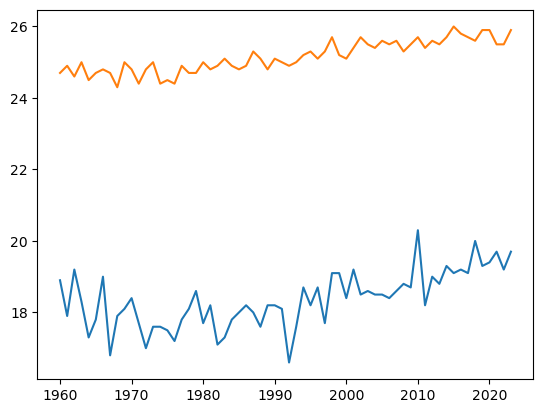

In [60]:
plt.plot(new_df[new_df['ISO3_code']=='SYR']['Year'], new_df[new_df['ISO3_code']=='SYR']['mean_temp'])

plt.plot(new_df[new_df['ISO3_code']=='BRA']['Year'], new_df[new_df['ISO3_code']=='BRA']['mean_temp'])

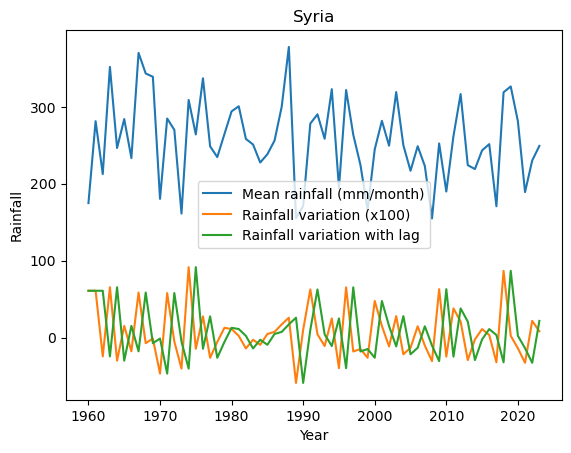

In [64]:
plt.plot(yearly_rainfall[yearly_rainfall['ISO3_code']=='SYR']['Year'],
         yearly_rainfall[yearly_rainfall['ISO3_code']=='SYR']['yearly_avg_rainfall'],
         label='Mean rainfall (mm/month)')
plt.plot(yearly_rainfall[yearly_rainfall['ISO3_code']=='SYR']['Year'],
         yearly_rainfall[yearly_rainfall['ISO3_code']=='SYR']['rainfall_var_t']*100,
         label='Rainfall variation (x100)')
plt.plot(yearly_rainfall[yearly_rainfall['ISO3_code']=='SYR']['Year'],
         yearly_rainfall[yearly_rainfall['ISO3_code']=='SYR']['rainfall_var_t_1']*100,
         label='Rainfall variation with lag')

plt.xlabel('Year')
plt.ylabel('Rainfall')
plt.legend()
plt.title('Syria')
plt.show()

In [65]:
dataset = new_df.merge(yearly_rainfall, on=['ISO3_code', 'Year'])

In [66]:
dataset.rename(columns={'ny_gdp_petr_rt_zs':'oil_rent'}, inplace=True)
dataset

ISO3_code  Year  pt_gdp_agriculture  oil_rent  democracy_polity  \
0          AFG  1960           38.627890  0.005149        -10.000000   
1          AFG  1961           38.627890  0.005149        -10.000000   
2          AFG  1962           38.627890  0.005149        -10.000000   
3          AFG  1963           38.627890  0.005149        -10.000000   
4          AFG  1964           38.627890  0.005149         -7.000000   
...        ...   ...                 ...       ...               ...   
8717       ZWE  2019            9.819262  0.050883         -1.692308   
8718       ZWE  2020            8.772859  0.029129         -1.692308   
8719       ZWE  2021            8.849899  0.047769         -1.692308   
8720       ZWE  2022            7.170550  0.000000         -1.692308   
8721       ZWE  2023            4.108254  0.000000         -1.692308   

               gdp      country  ethnic_fractionation_index  mean_temp  \
0     5.621148e+09  Afghanistan                       0.586       11.9   
1     5.621148e+09  Afghanistan                       0.588       12.3   
2     5.621148e+09  Afghanistan                       0.591       12.0   
3     5.621148e+09  Afghanistan                       0.593       12.8   
4     5.621148e+09  Afghanistan                       0.596       11.3   
...            ...          ...                         ...        ...   
8717  2.062108e+10     Zimbabwe                       0.415       22.4   
8718  1.900914e+10     Zimbabwe                       0.415       22.0   
8719  2.061884e+10     Zimbabwe                       0.415       22.0   
8720  2.188468e+10     Zimbabwe                       0.415       21.9   
8721  2.305261e+10     Zimbabwe                       0.415       22.1   

      yearly_avg_rainfall  rainfall_var_t  rainfall_var_t_1  
0              318.565807       -0.075064         -0.075064  
1              294.653108       -0.075064         -0.075064  
2              243.503638       -0.173592         -0.075064  
3              307.702050        0.263645         -0.173592  
4              300.362434       -0.023853          0.263645  
...                   ...             ...               ...  
8717           647.373718        0.176221         -0.316445  
8718           586.835256       -0.093514          0.176221  
8719           543.462821       -0.073909         -0.093514  
8720           635.176282        0.168758         -0.073909  
8721           612.769872       -0.035276          0.168758  

[8722 rows x 12 columns]

In [67]:
dataset[dataset['ISO3_code']=='USA']

Empty DataFrame
Columns: [ISO3_code, Year, pt_gdp_agriculture, oil_rent, democracy_polity, gdp, country, ethnic_fractionation_index, mean_temp, yearly_avg_rainfall, rainfall_var_t, rainfall_var_t_1]
Index: []

### Add features

- GDP variation (`gdp_g`)
- Rainfall difference from all-time average (`rainfall_diff_from_mean_norm`)
- Cumulative difference in rainfall from all-time mean (`cum_rainfall_diff`)
- Number of years in a row we are below average (`n_below_rainfall`)
- (Categorical variable) whether oil rent average over years is above 20% (`oil_prod`)
- (Categorical variable) whether % GDP due to agriculture average over years is above 40% (`agricultural`)
- Mean surface temperature derivative (`mean_temp_t`)
- Mean surface temperature with a lag of one year (`mean_temp_t_1`)

In [68]:
agriculture_cutoff = 30
oil_cutoff = 5

gdp_g = pd.DataFrame()
for country in dataset['ISO3_code'].unique():
    gdp = dataset[dataset['ISO3_code']==country].gdp
    gdp_diff = diff(gdp)
    gdp_diff = np.concatenate(([gdp_diff[0]], gdp_diff))
    gdp_diff[np.where(gdp_diff > 1)] = 0

    years = dataset[dataset['ISO3_code']==country].Year
    mean_rainfall = dataset[dataset['ISO3_code']==country].yearly_avg_rainfall.mean()
    avg_rainfall = dataset[dataset['ISO3_code']==country].yearly_avg_rainfall

    x = (avg_rainfall - mean_rainfall)/mean_rainfall

    n_below = []
    prev = 0
    for i, yr in enumerate(years):
        if avg_rainfall.to_list()[i] < mean_rainfall:
            prev += 1
        else:
            prev = 0
        n_below.append(prev)

    mean_oil = dataset[dataset['ISO3_code']==country].oil_rent.mean()
    mean_agr = dataset[dataset['ISO3_code']==country].pt_gdp_agriculture.mean()

    mean_temp = dataset[dataset['ISO3_code']==country].mean_temp
    mean_temp_t = diff(mean_temp)
    mean_temp_t = np.concatenate(([mean_temp_t[0]], mean_temp_t))
    mean_temp_t_1 = diff(mean_temp, lag=1)
    mean_temp_t_1 = np.concatenate(([mean_temp_t_1[0], mean_temp_t_1[1]], mean_temp_t_1))

    to_add = pd.DataFrame({'ISO3_code': [country]*len(gdp_diff),
                           'Year': years,
                           'gdp_g': gdp_diff,
                           'rainfall_diff_from_mean_norm': x,
                           'n_below_rainfall': n_below,
                           'oil_prod': [mean_oil >= oil_cutoff] * len(gdp_diff),
                           'agricultural': [mean_agr >= agriculture_cutoff] * len(gdp_diff),
                           'low_oil_high_agr': [(mean_oil < oil_cutoff) & (mean_agr >= agriculture_cutoff)] * len(gdp_diff),
                           'cum_rainfall_diff': np.cumsum(x),
                           'mean_temp_t': mean_temp_t,
                           'mean_temp_t_1': mean_temp_t_1
                          })
    gdp_g = pd.concat([gdp_g, to_add])

dataset = dataset.merge(gdp_g, on=['ISO3_code', 'Year'])

dataset.sample(15)

/home/irem/nature-and-conflicts/01_exploratory_data_analysis/rainfall/utils.py:57: RuntimeWarning: divide by zero encountered in divide
  res = (arr_t - arr_t_1)/(arr_t_1)


ISO3_code  Year  pt_gdp_agriculture   oil_rent  democracy_polity  \
256        ARG  1960           12.904163   0.183779          5.000000   
8022       TLS  1992           32.204285   0.000000          7.176471   
6321       PER  1961           19.156353   0.104811          5.000000   
8236       TUR  2011            8.173956   0.123984          9.000000   
6944       SAU  2002            5.037538  31.342447        -10.000000   
2832       GBR  1965            1.275553   0.000144         10.000000   
7423       SVK  1969            2.614928   0.000492         -7.000000   
8415       UKR  1998           12.068075   0.181695          7.000000   
5392       MNG  1992           25.557106   0.000000          9.000000   
50         AFG  2010           26.210068   0.005149         -6.336735   
6164       OMN  1996            2.198443  36.199116         -9.000000   
5710       NER  1990           29.442250   0.000000         -4.000000   
1063       BOL  1988           15.735381   1.456433          9.000000   
20         AFG  1980           38.627890   1.350059         -6.336735   
753        BEN  1998           36.576650   0.101033          6.000000   

               gdp         country  ethnic_fractionation_index  mean_temp  \
256   1.507978e+11       Argentina                       0.066       15.2   
8022  5.887709e+08      East Timor                       0.864       25.4   
6321  2.953612e+10            Peru                       0.637       19.6   
8236  6.829566e+11          Turkey                       0.505       11.1   
6944  3.524645e+11    Saudi Arabia                       0.215       25.9   
2832  9.312579e+11  United Kingdom                       0.311        7.9   
7423  3.630382e+10        Slovakia                       0.251        6.7   
8415  6.607774e+10         Ukraine                       0.412        8.6   
5392  3.170772e+09        Mongolia                       0.331        0.1   
50    1.535461e+10     Afghanistan                       0.757       13.7   
6164  4.020338e+10            Oman                       0.445       27.1   
5710  3.860673e+09           Niger                       0.670       27.8   
1063  1.102601e+10         Bolivia                       0.593       21.7   
20    5.621148e+09     Afghanistan                       0.662       12.7   
753   5.577293e+09           Benin                       0.779       28.4   

      yearly_avg_rainfall  ...  rainfall_var_t_1     gdp_g  \
256            429.814655  ...          0.157245  0.054278   
8022          1201.183333  ...          0.067291  0.104595   
6321          1424.909546  ...          0.041754  0.073471   
8236           532.215447  ...         -0.086046  0.112001   
6944            91.575024  ...          0.052249 -0.006884   
2832           919.019676  ...         -0.115928  0.021303   
7423           619.281746  ...          0.090783  0.000000   
8415           509.834226  ...          0.161571 -0.019000   
5392           197.318715  ...         -0.121724 -0.092565   
50             270.183862  ...          0.309344  0.143624   
6164            45.558962  ...          1.563308  0.030459   
5710            97.064214  ...         -0.143444 -0.013085   
1063           937.151842  ...         -0.029530  0.029095   
20             314.535714  ...          0.133317  0.000000   
753            905.360417  ...         -0.087931  0.039610   

      rainfall_diff_from_mean_norm  n_below_rainfall  oil_prod  agricultural  \
256                      -0.129531                 1     False         False   
8022                      0.057462                 0     False         False   
6321                      0.015870                 0     False         False   
8236                      0.045026                 0     False         False   
6944                      0.062900                 0      True         False   
2832                      0.024420                 0     False         False   
7423                     -0.074820                

### Some sanity checks

In [69]:
subset = dataset[['ISO3_code',
               'Year',
               'yearly_avg_rainfall',
               'pt_gdp_agriculture',
               'gdp',
               'gdp_g',
               'oil_rent',
               'rainfall_diff_from_mean_norm',
               'n_below_rainfall',
               'rainfall_var_t',
               'rainfall_var_t_1',
               'mean_temp',
               'oil_prod',
               'agricultural',
               'low_oil_high_agr',
               'cum_rainfall_diff'
              ]].copy()

subset.dropna(inplace=True)
subset[subset['ISO3_code']=='UGA']

ISO3_code  Year  yearly_avg_rainfall  pt_gdp_agriculture           gdp  \
8313       UGA  1960           957.014403           49.874860  4.983496e+09   
8314       UGA  1961          1275.412551           49.922844  4.983496e+09   
8315       UGA  1962          1113.368313           49.180824  4.983496e+09   
8316       UGA  1963          1138.208848           47.512920  4.983496e+09   
8317       UGA  1964          1031.688272           47.243397  4.983496e+09   
...        ...   ...                  ...                 ...           ...   
8372       UGA  2019          1298.510288           22.945509  3.960005e+10   
8373       UGA  2020          1215.872428           23.929033  4.076877e+10   
8374       UGA  2021          1122.934156           23.841805  4.221059e+10   
8375       UGA  2022          1142.887860           24.011723  4.414722e+10   
8376       UGA  2023          1054.117284           24.089575  4.650334e+10   

         gdp_g  oil_rent  rainfall_diff_from_mean_norm  n_below_rainfall  \
8313  0.000000       0.0                     -0.067322                 1   
8314  0.000000       0.0                      0.242980                 0   
8315  0.000000       0.0                      0.085056                 0   
8316  0.000000       0.0                      0.109265                 0   
8317  0.000000       0.0                      0.005453                 0   
...        ...       ...                           ...               ...   
8372  0.064387       0.0                      0.265490                 0   
8373  0.029513       0.0                      0.184954                 0   
8374  0.035366       0.0                      0.094379                 0   
8375  0.045880       0.0                      0.113825                 0   
8376  0.053370       0.0                      0.027312                 0   

      rainfall_var_t  rainfall_var_t_1  mean_temp  oil_prod  agricultural  \
8313        0.332699          0.332699       22.7     False          True   
8314        0.332699          0.332699       22.4     False          True   
8315       -0.127052          0.332699       22.2     False          True   
8316        0.022311         -0.127052       22.4     False          True   
8317       -0.093586          0.022311       22.3     False          True   
...              ...               ...        ...       ...           ...   
8372        0.221933         -0.084493       23.5     False          True   
8373       -0.063641          0.221933       23.5     False          True   
8374       -0.076438         -0.063641       23.4     False          True   
8375        0.017769         -0.076438       23.4     False          True   
8376       -0.077672          0.017769       23.9     False          True   

      low_oil_high_agr  cum_rainfall_diff  
8313              True      -6.732184e-02  
8314              True       1.756578e-01  
8315              True       2.607139e-01  
8316              True       3.699788e-01  
8317              True       3.754320e-01  
...                ...                ...  
8372              True      -4.204690e-01  
8373              True      -2.355154e-01  
8374              True      -1.411368e-01  
8375              True      -2.731178e-02  
8376              True       3.577000e-15  

[64 rows x 16 columns]

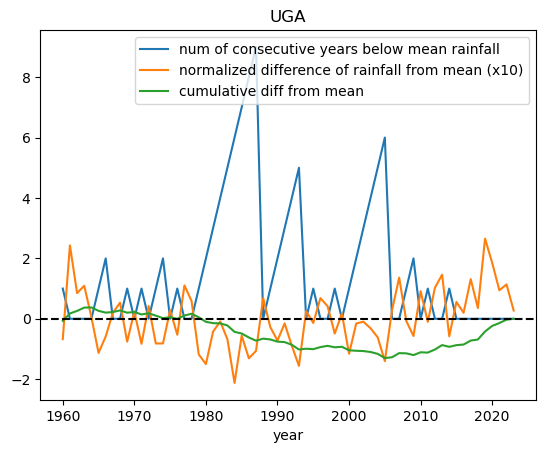

In [70]:
plt.plot(subset[subset['ISO3_code']=='UGA'].Year,
         subset[subset['ISO3_code']=='UGA'].n_below_rainfall,
         label='num of consecutive years below mean rainfall')

plt.plot(subset[subset['ISO3_code']=='UGA'].Year,
         subset[subset['ISO3_code']=='UGA'].rainfall_diff_from_mean_norm*10,
         label='normalized difference of rainfall from mean (x10)')

plt.plot(subset[subset['ISO3_code']=='UGA'].Year,
         subset[subset['ISO3_code']=='UGA'].cum_rainfall_diff,
         label='cumulative diff from mean')

y = subset[subset['ISO3_code']=='UGA'].rainfall_diff_from_mean_norm.to_numpy()
x = subset[subset['ISO3_code']=='UGA'].Year


plt.axhline(0, color='k', linestyle='dashed')

plt.xlabel('year')
plt.legend()
plt.title('UGA')
plt.show()

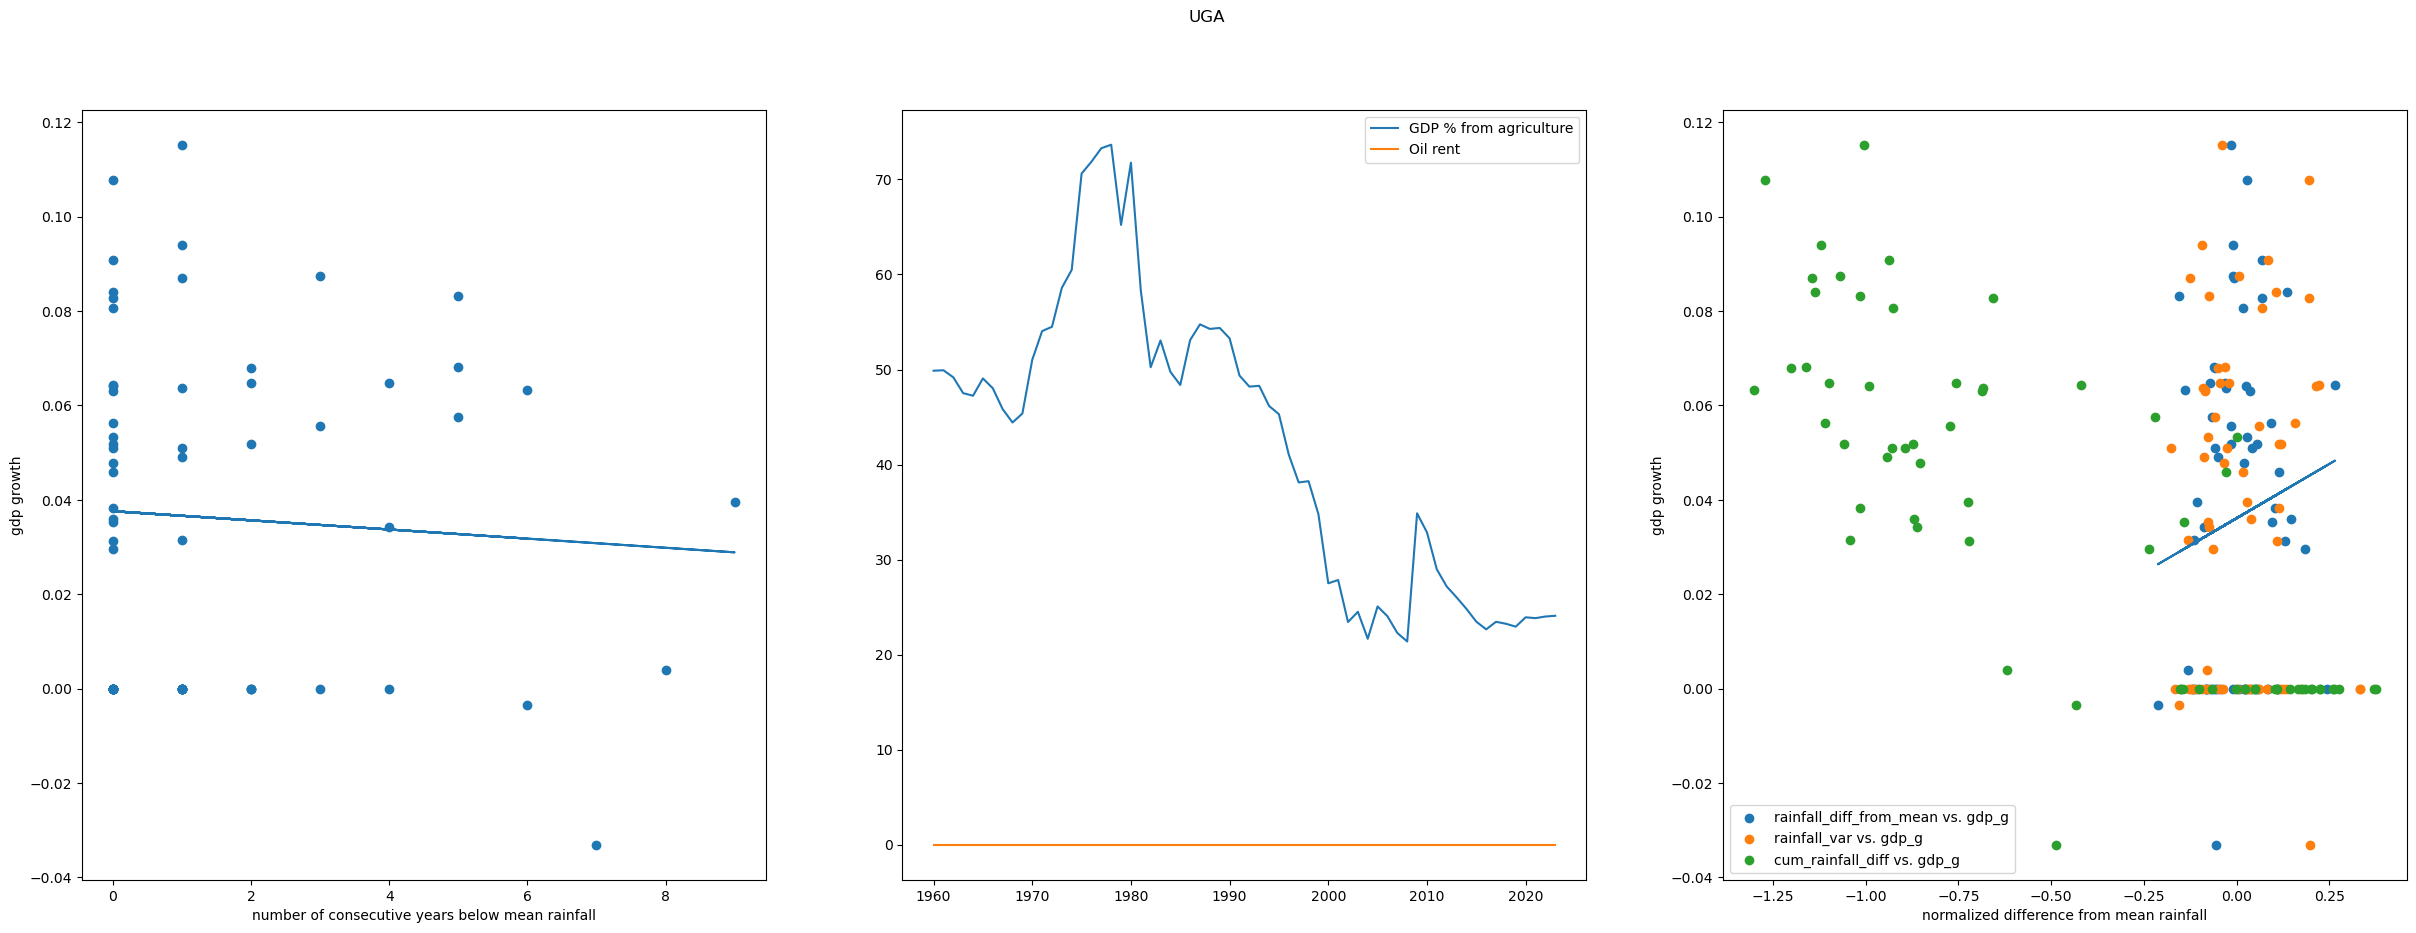

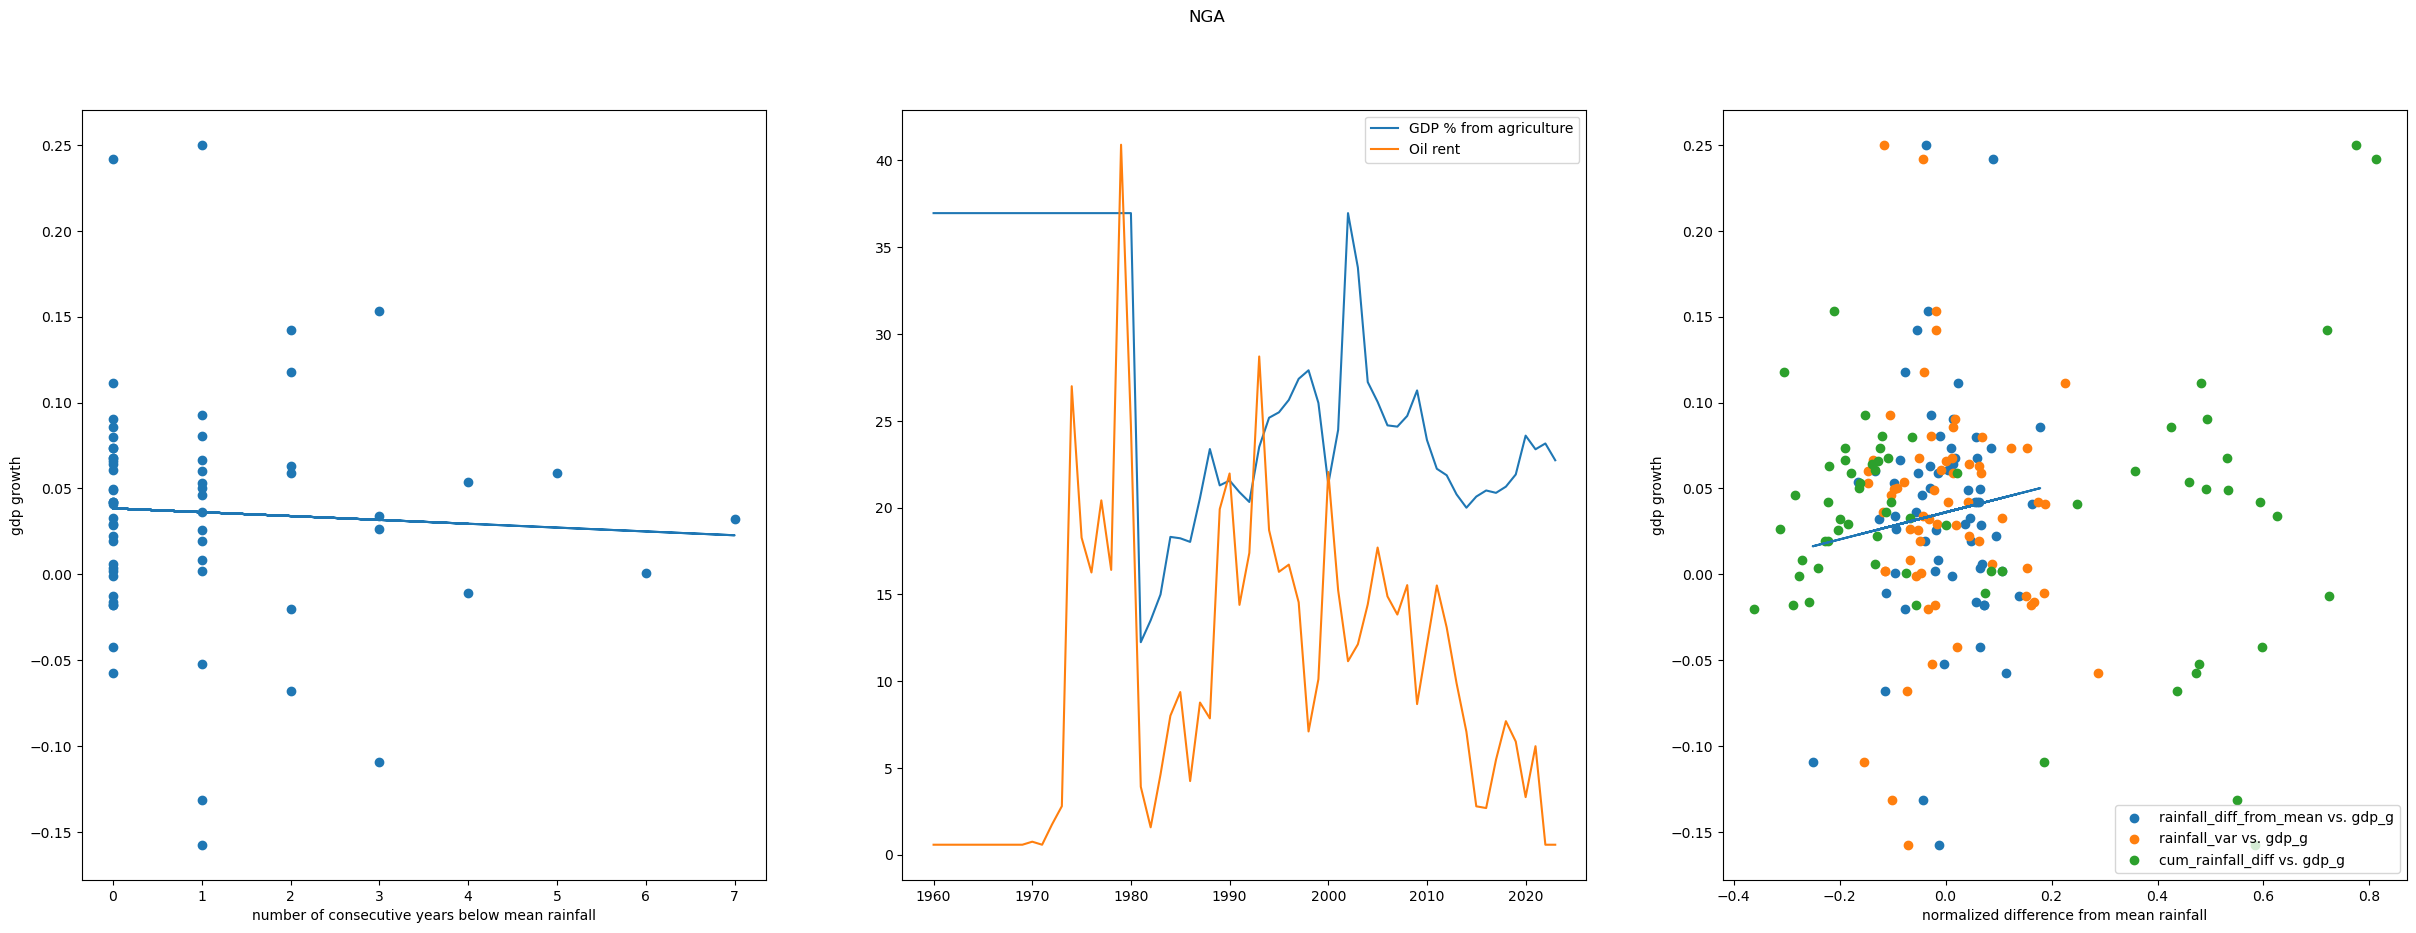

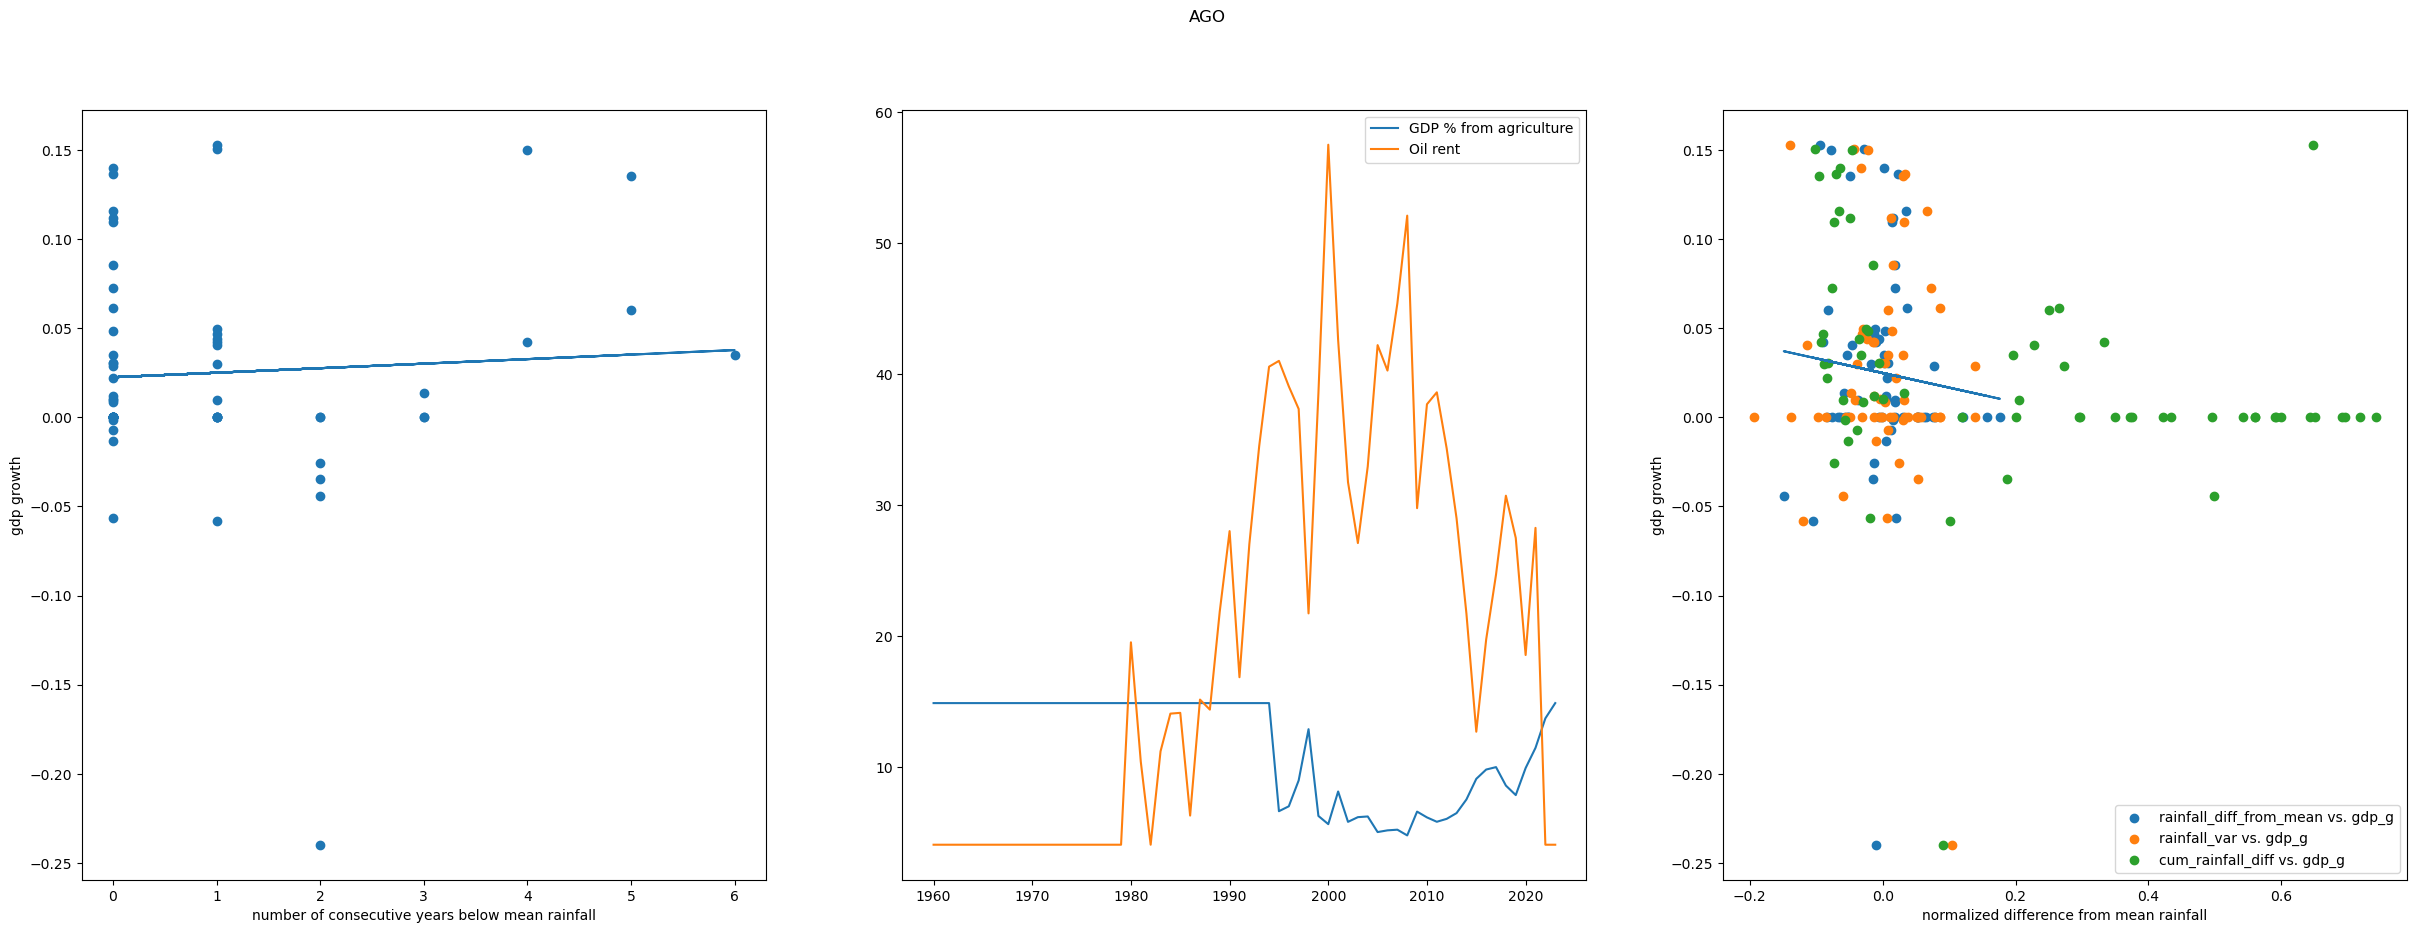

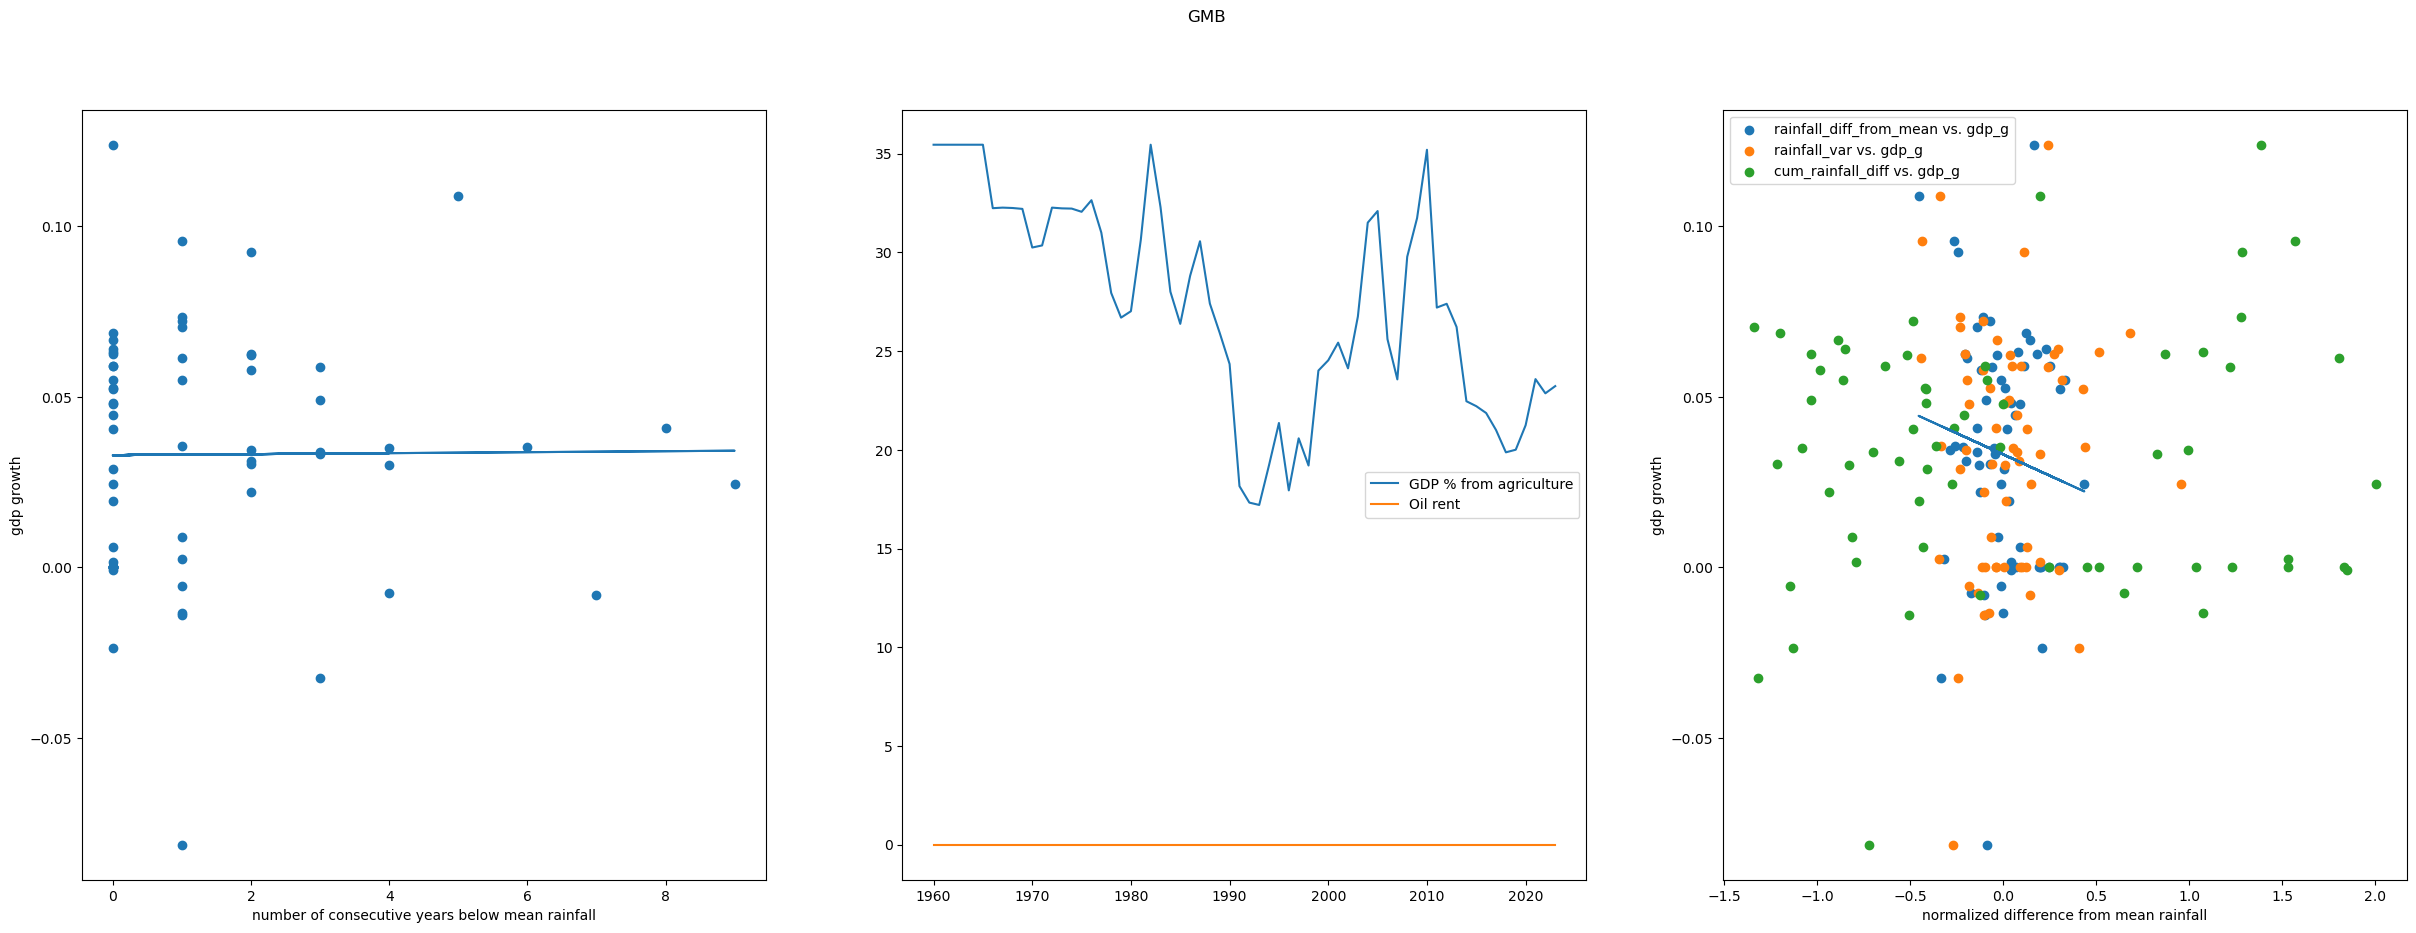

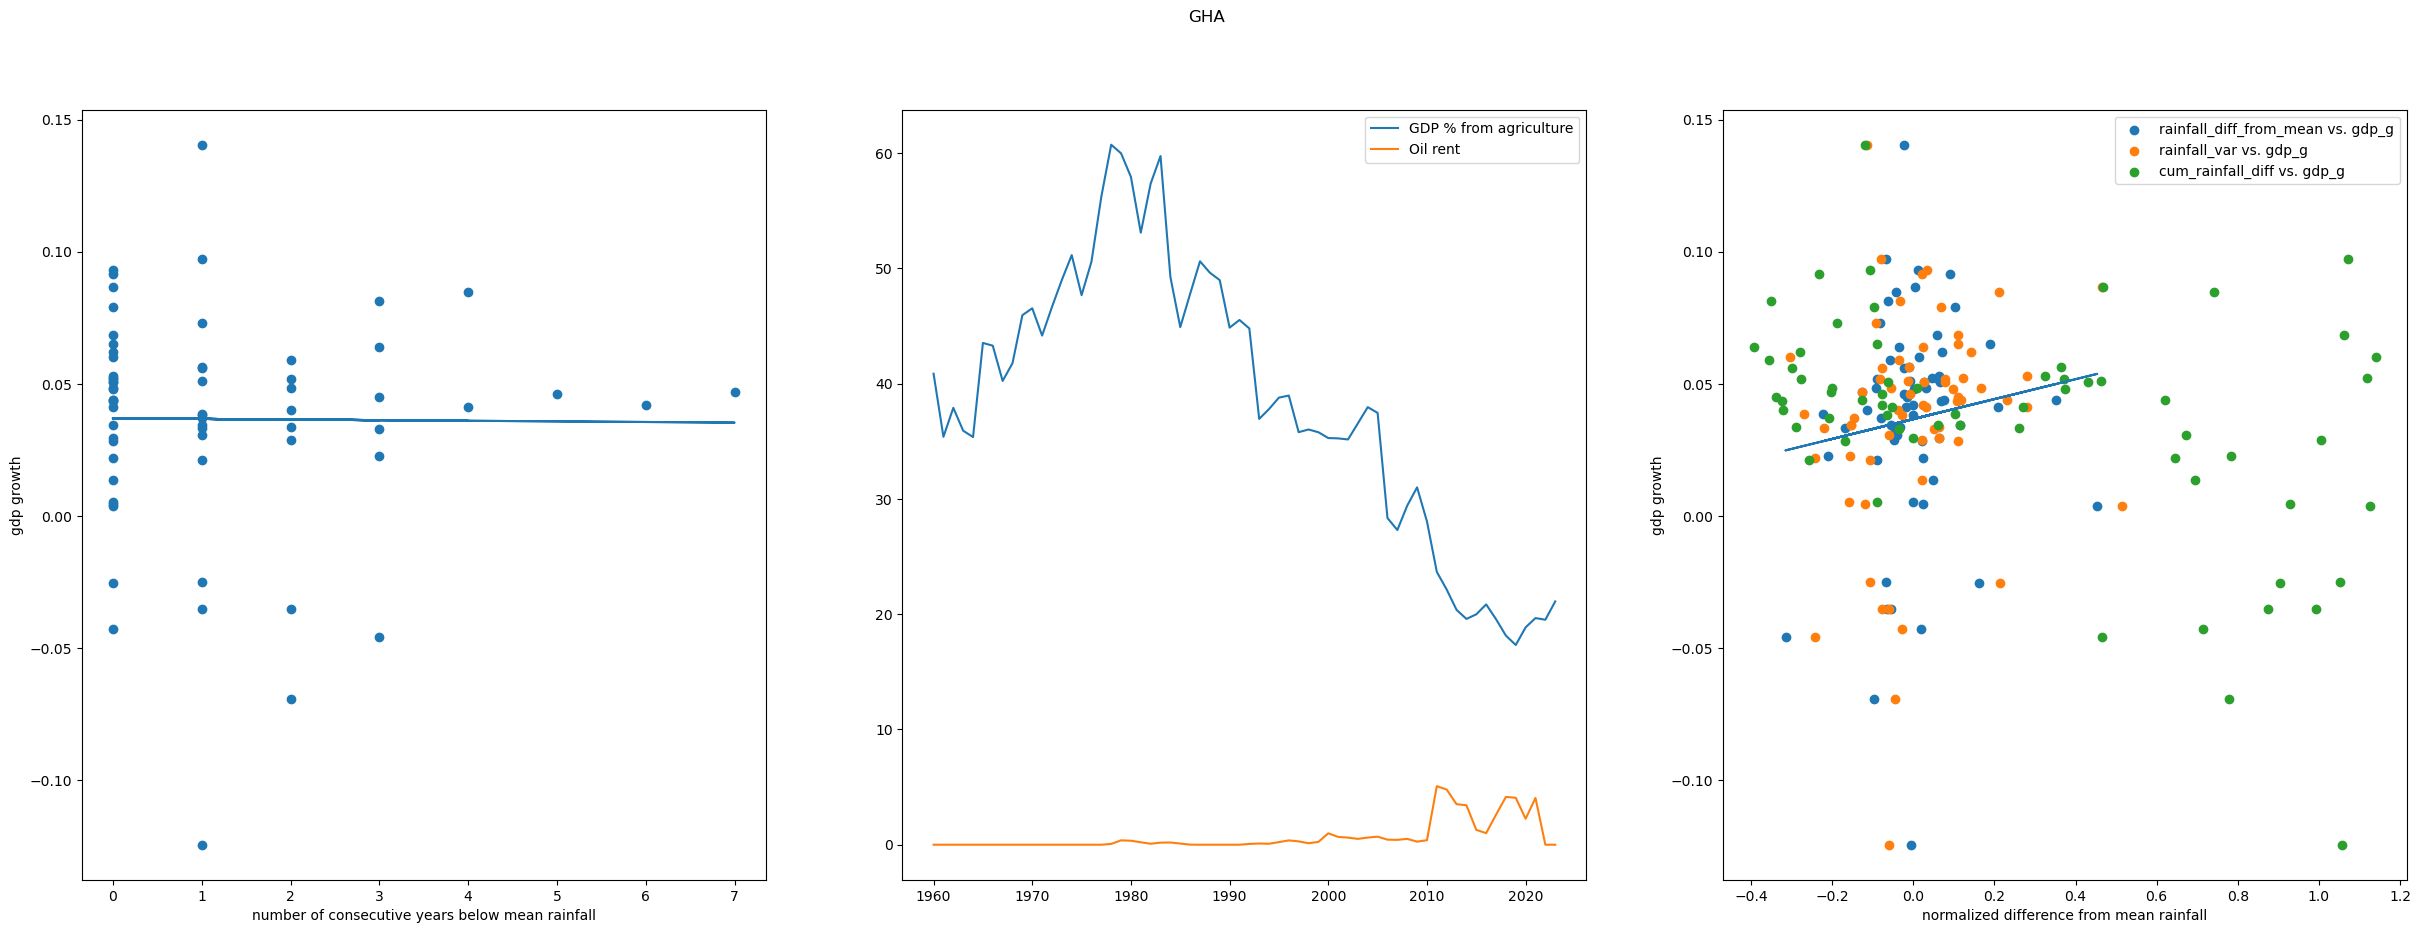

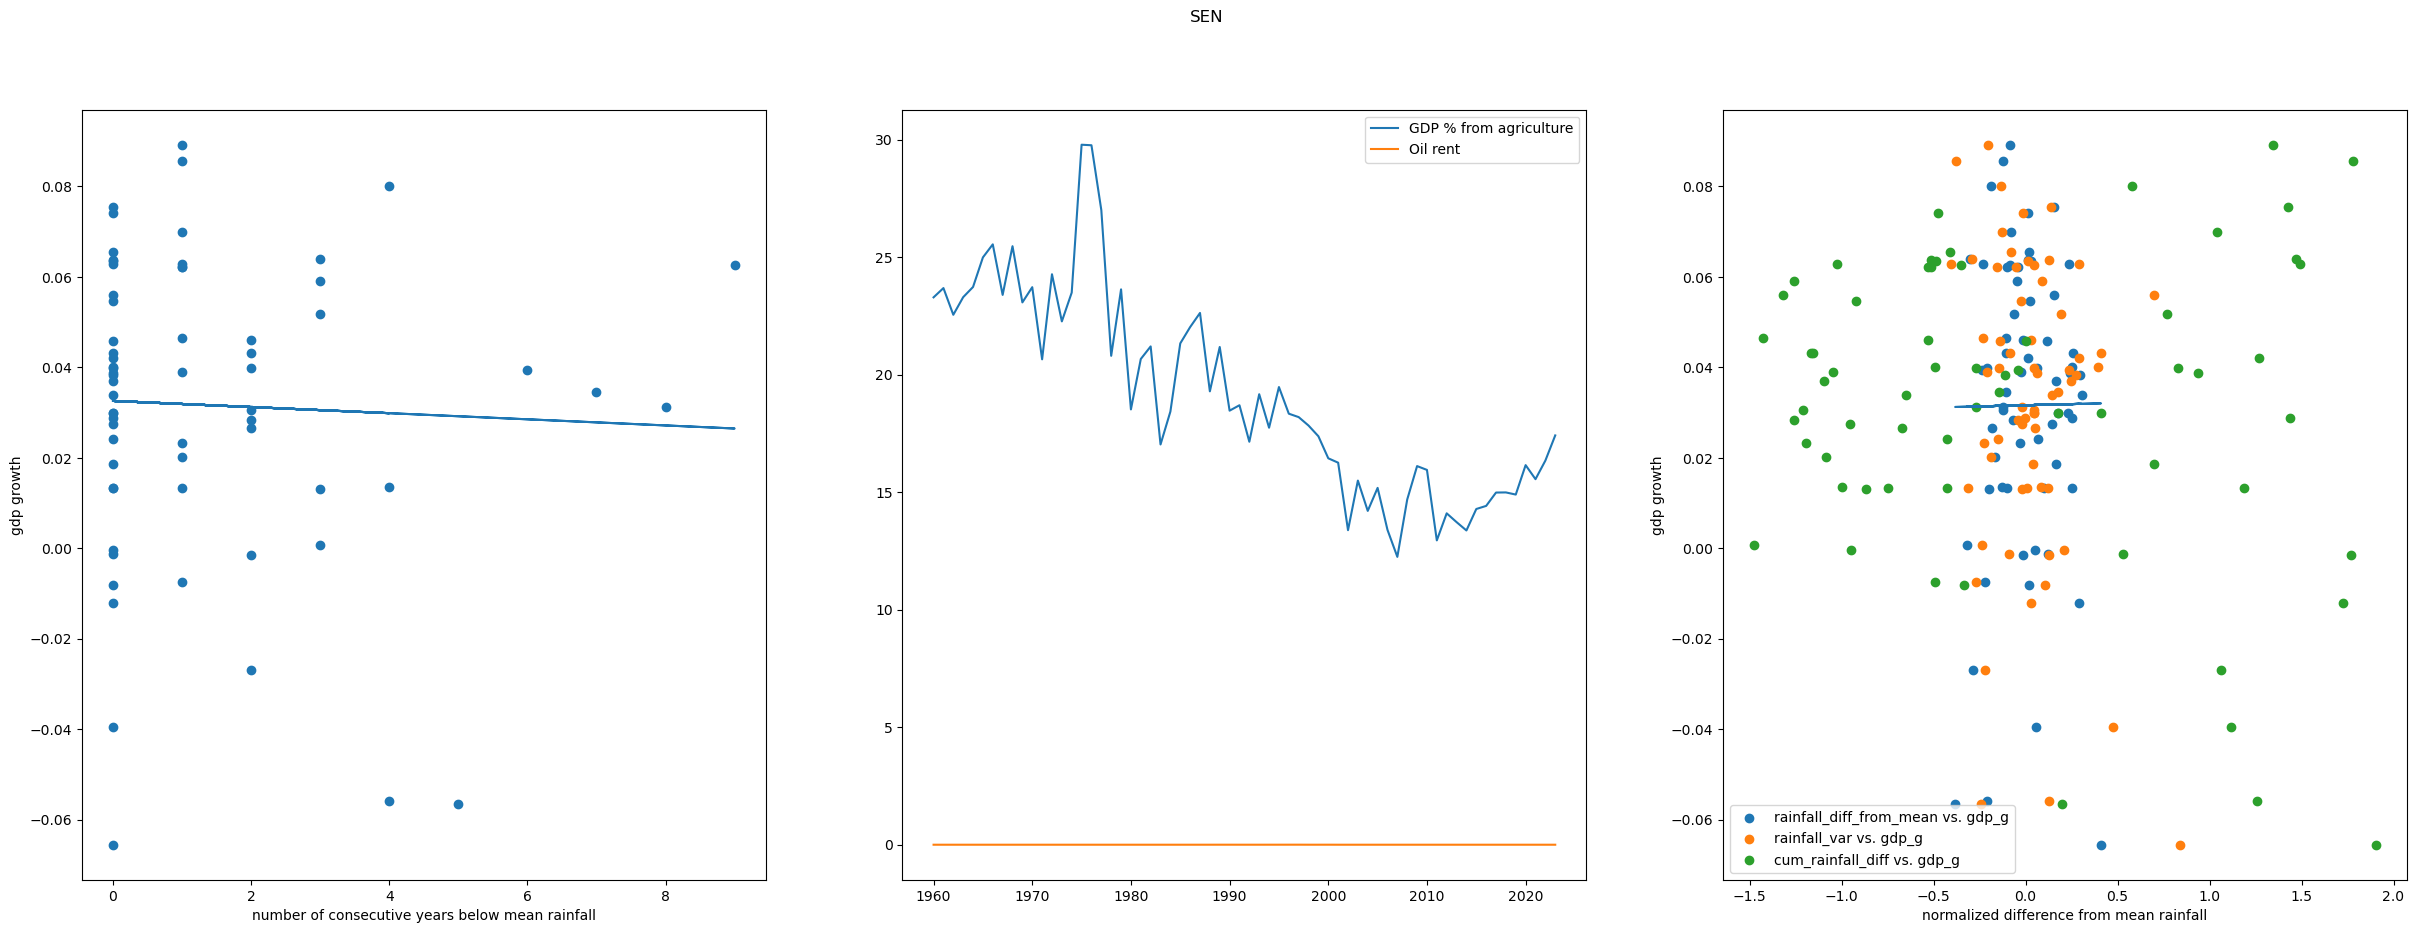

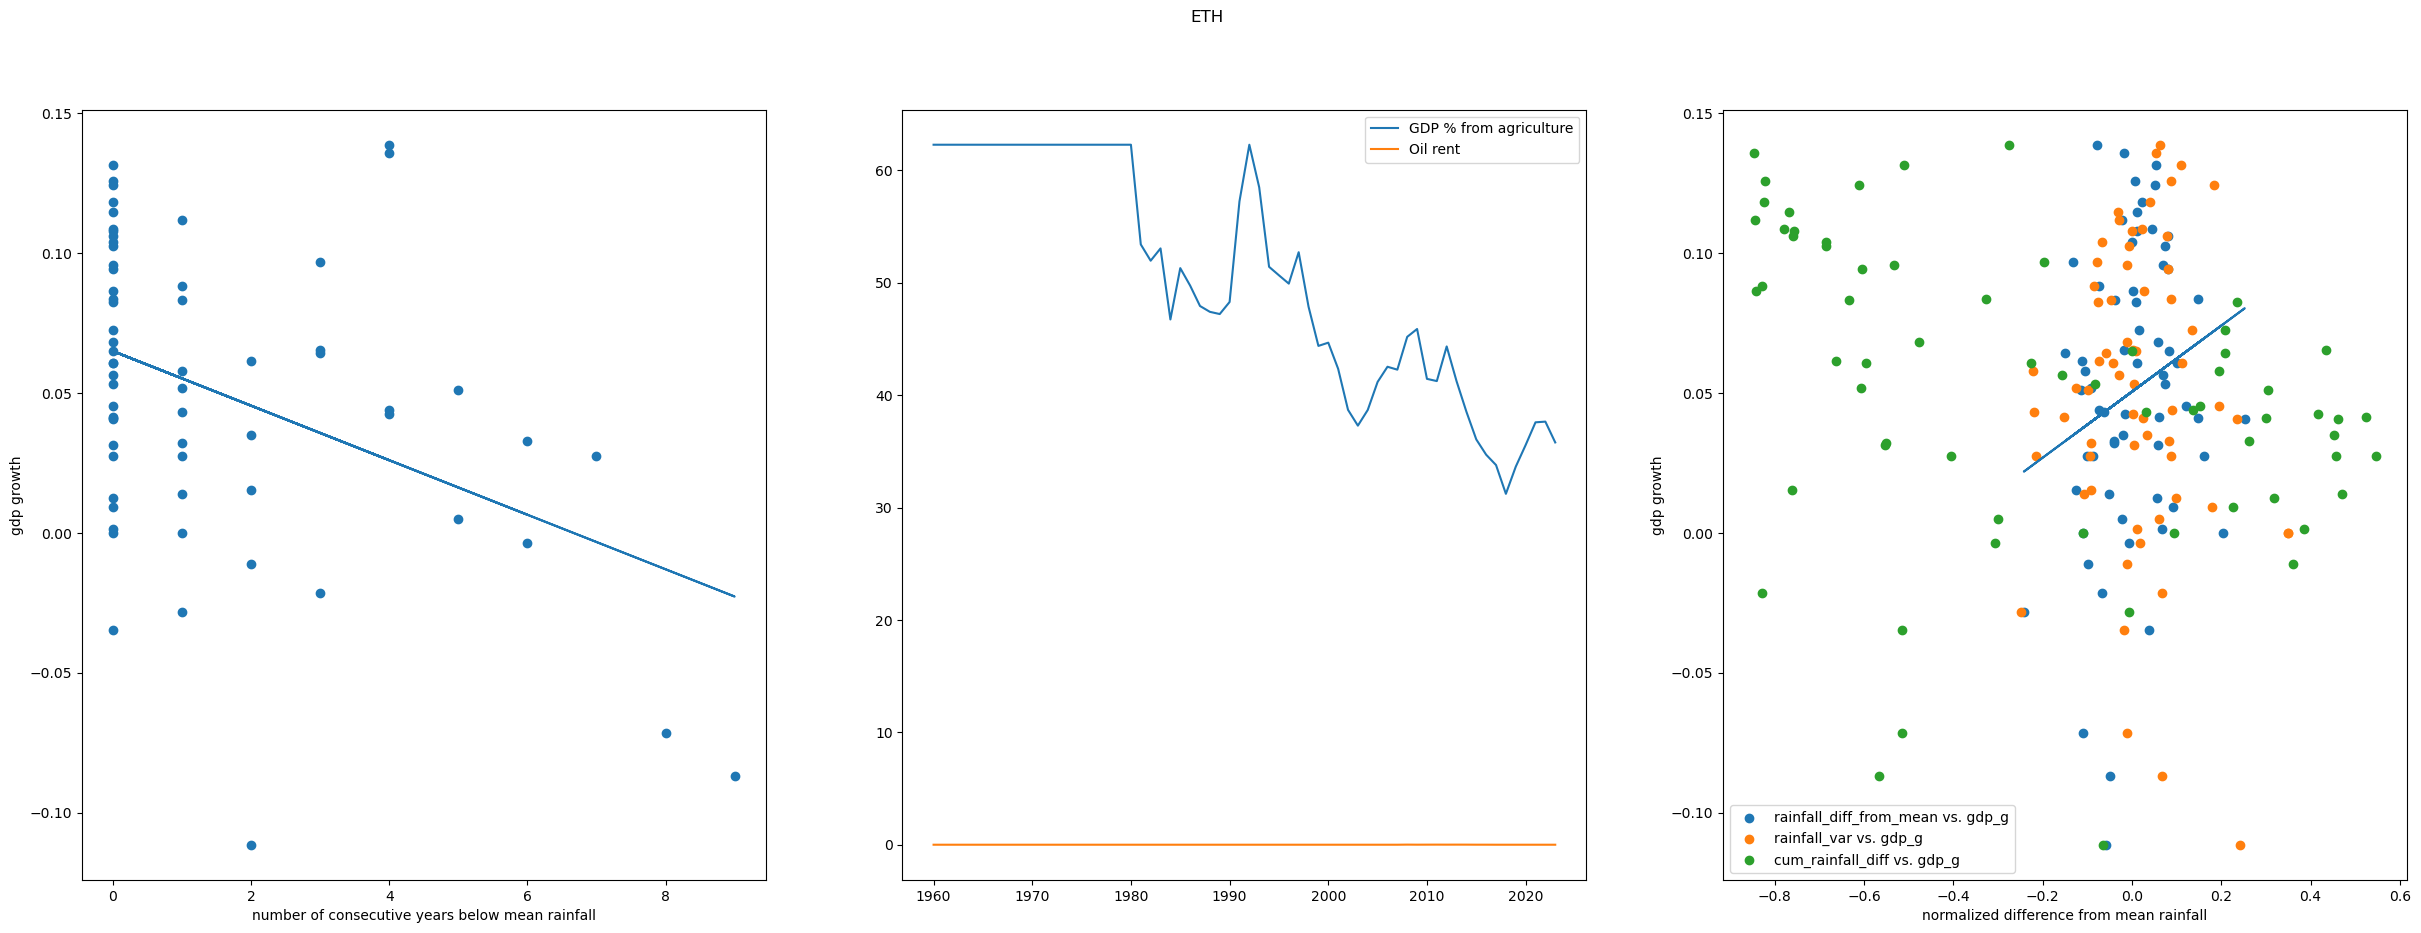

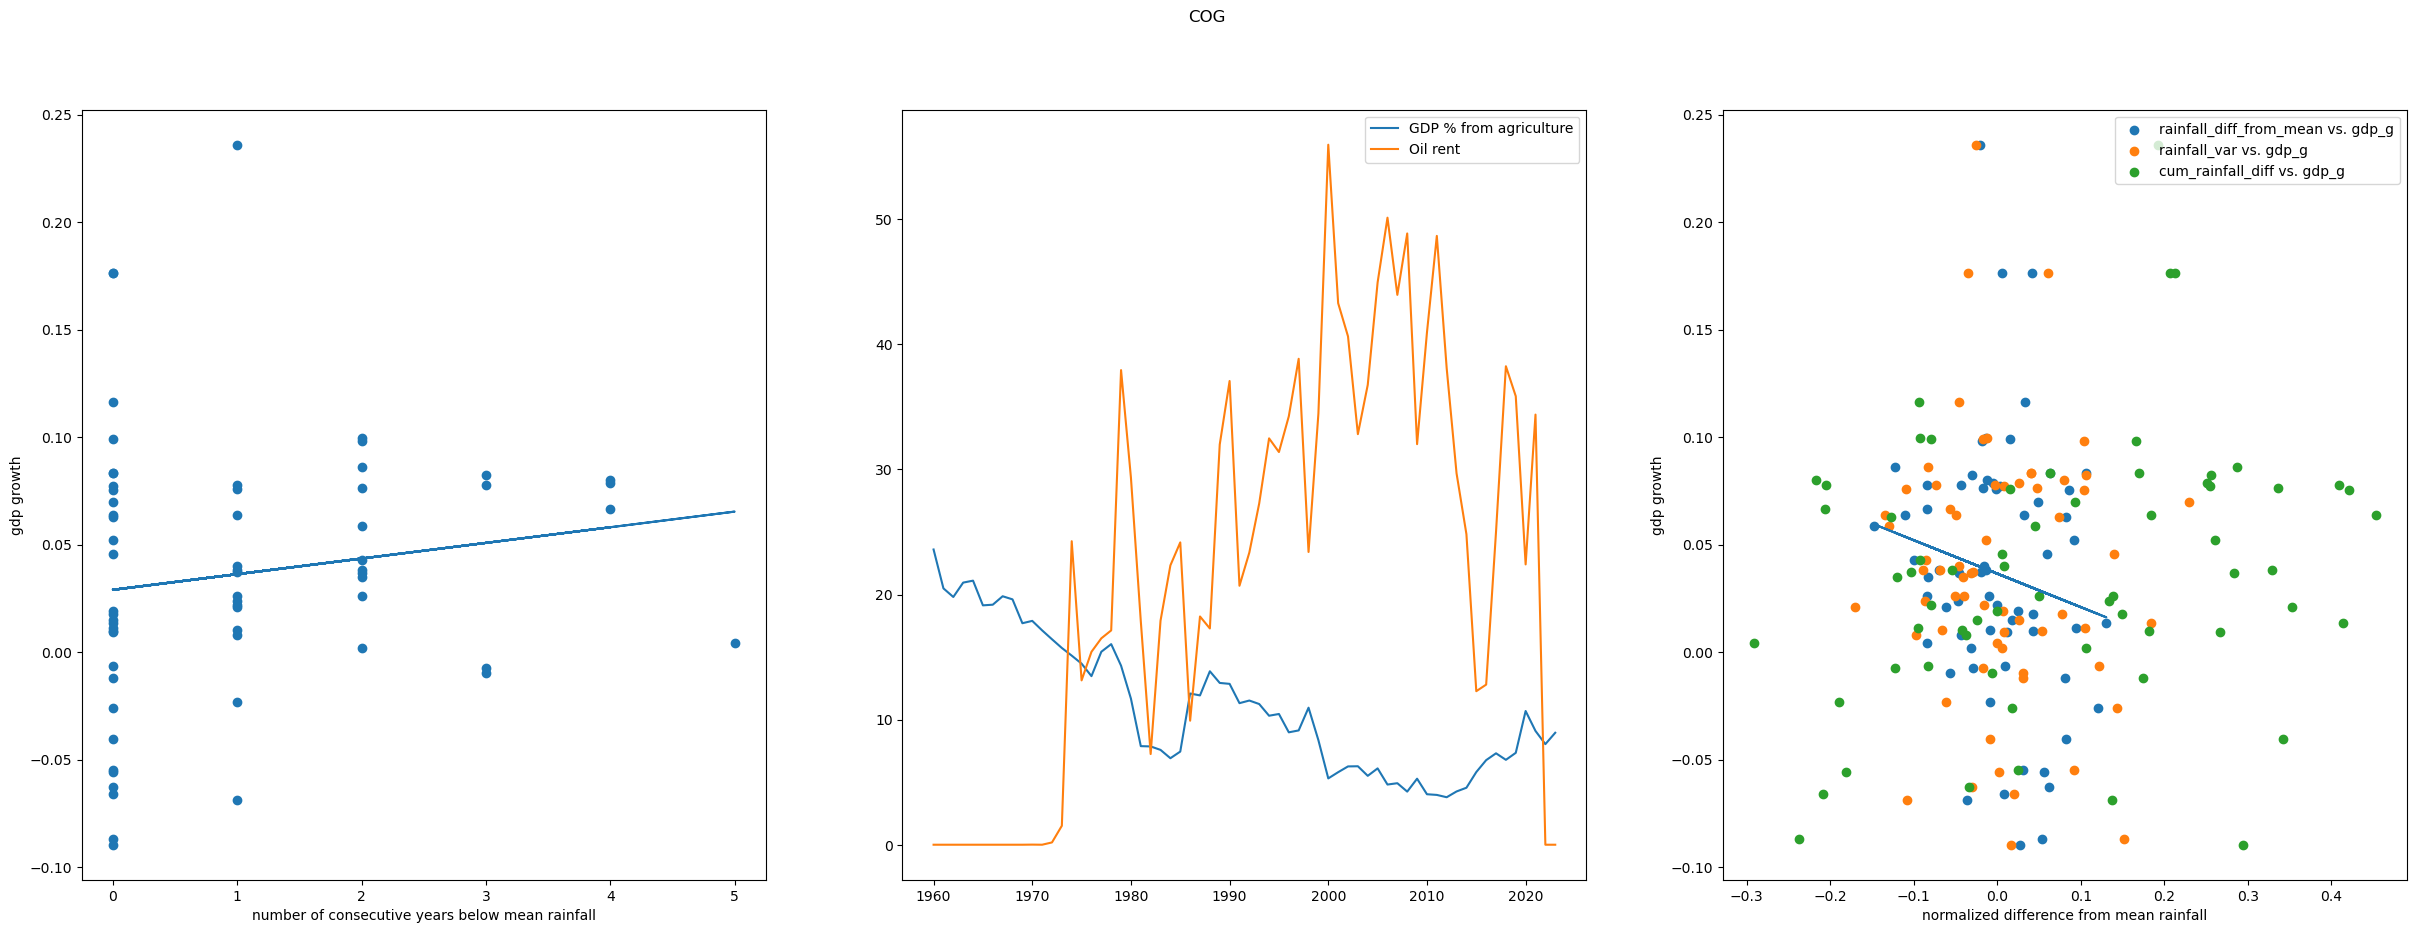

In [71]:
from sklearn.linear_model import LinearRegression

countries = ['UGA', 'NGA', 'AGO', 'GMB', 'GHA', 'SEN', 'ETH', 'COG']

for country in countries:
    fig, ax = plt.subplots(1,3,figsize=(30,10))
    country_subset = subset[subset['ISO3_code']==country]

    ax[0].scatter(country_subset['n_below_rainfall'], country_subset['gdp_g'])

    ols = LinearRegression()
    ols.fit(country_subset[['n_below_rainfall']], country_subset['gdp_g'])
    yp = ols.predict(country_subset[['n_below_rainfall']])
    ax[0].plot(country_subset['n_below_rainfall'], yp)

    ax[0].set_xlabel('number of consecutive years below mean rainfall')
    ax[0].set_ylabel('gdp growth')

    ax[1].plot(country_subset['Year'], country_subset['pt_gdp_agriculture'], label='GDP % from agriculture')
    ax[1].plot(country_subset['Year'], country_subset['oil_rent'], label='Oil rent')
    ax[1].legend()

    ax[2].scatter(country_subset['rainfall_diff_from_mean_norm'], country_subset['gdp_g'], label='rainfall_diff_from_mean vs. gdp_g')
    ols.fit(country_subset[['rainfall_diff_from_mean_norm']], country_subset['gdp_g'])
    yp = ols.predict(country_subset[['rainfall_diff_from_mean_norm']])
    ax[2].plot(country_subset['rainfall_diff_from_mean_norm'], yp)
    ax[2].set_xlabel('normalized difference from mean rainfall')
    ax[2].set_ylabel('gdp growth')

    ax[2].scatter(country_subset['rainfall_var_t'], country_subset['gdp_g'], label='rainfall_var vs. gdp_g')
    ax[2].scatter(country_subset['cum_rainfall_diff'], country_subset['gdp_g'], label='cum_rainfall_diff vs. gdp_g')
    ax[2].legend()

    plt.suptitle(country)
    plt.show()

## Pairplots

In [72]:
import seaborn as sns

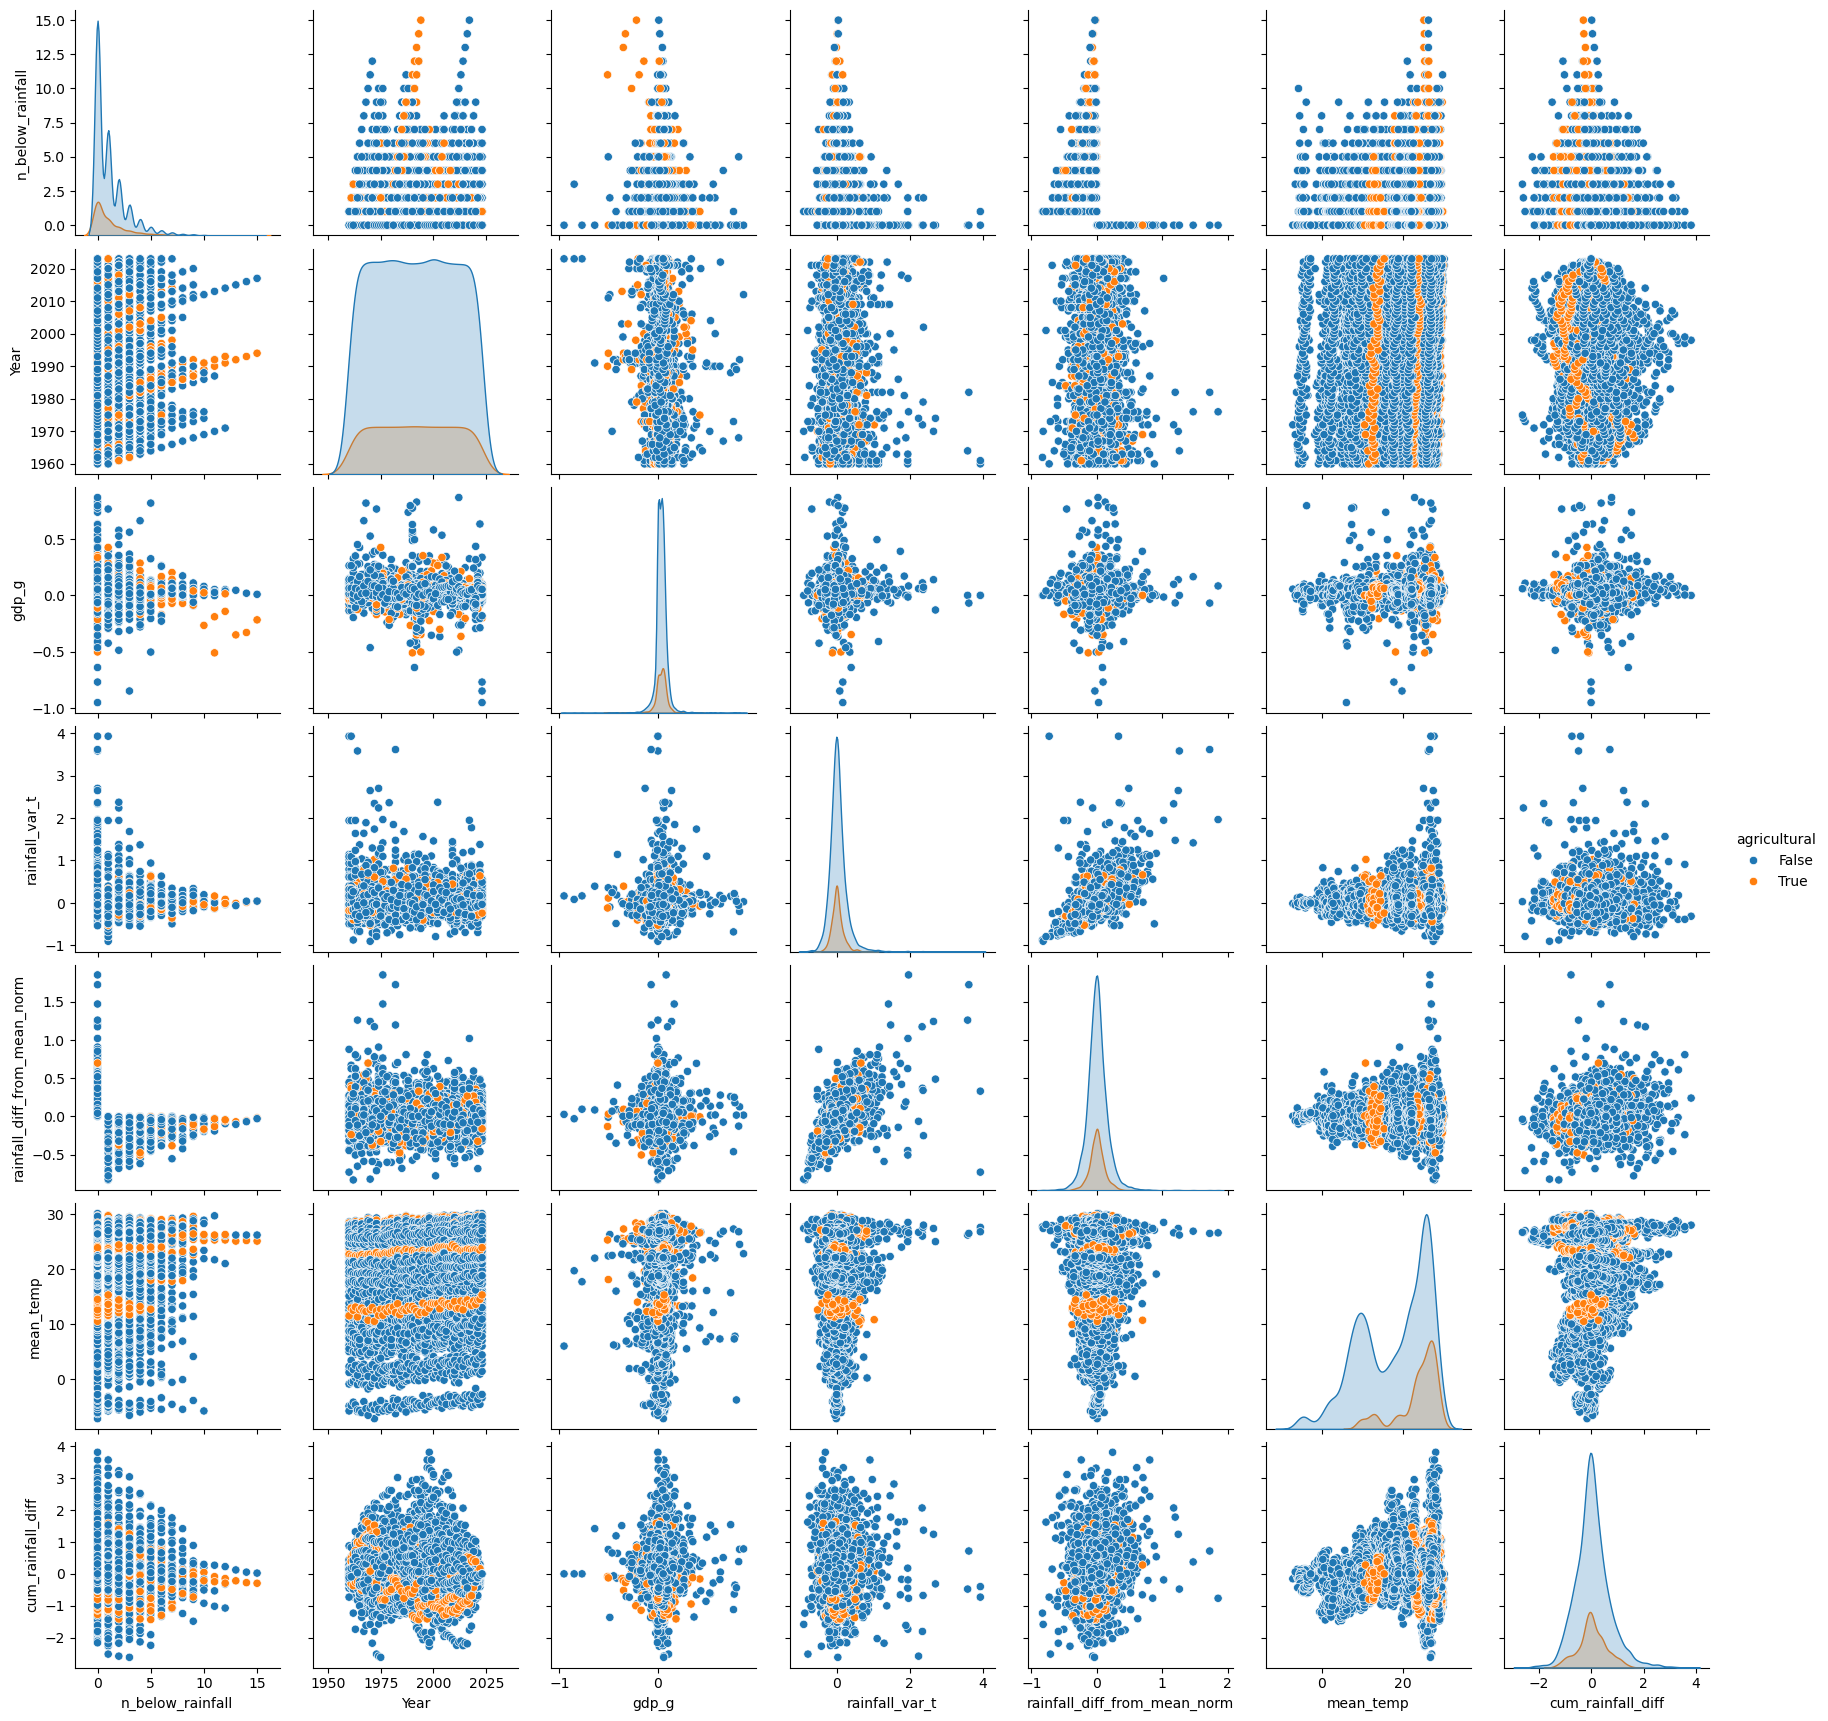

In [73]:
plot_feats = ['n_below_rainfall', 'Year', 'gdp_g', 'rainfall_var_t', 'rainfall_diff_from_mean_norm', 'mean_temp', 'cum_rainfall_diff']
sns.pairplot(subset,
             x_vars=plot_feats,
             y_vars=plot_feats,
             hue='agricultural')

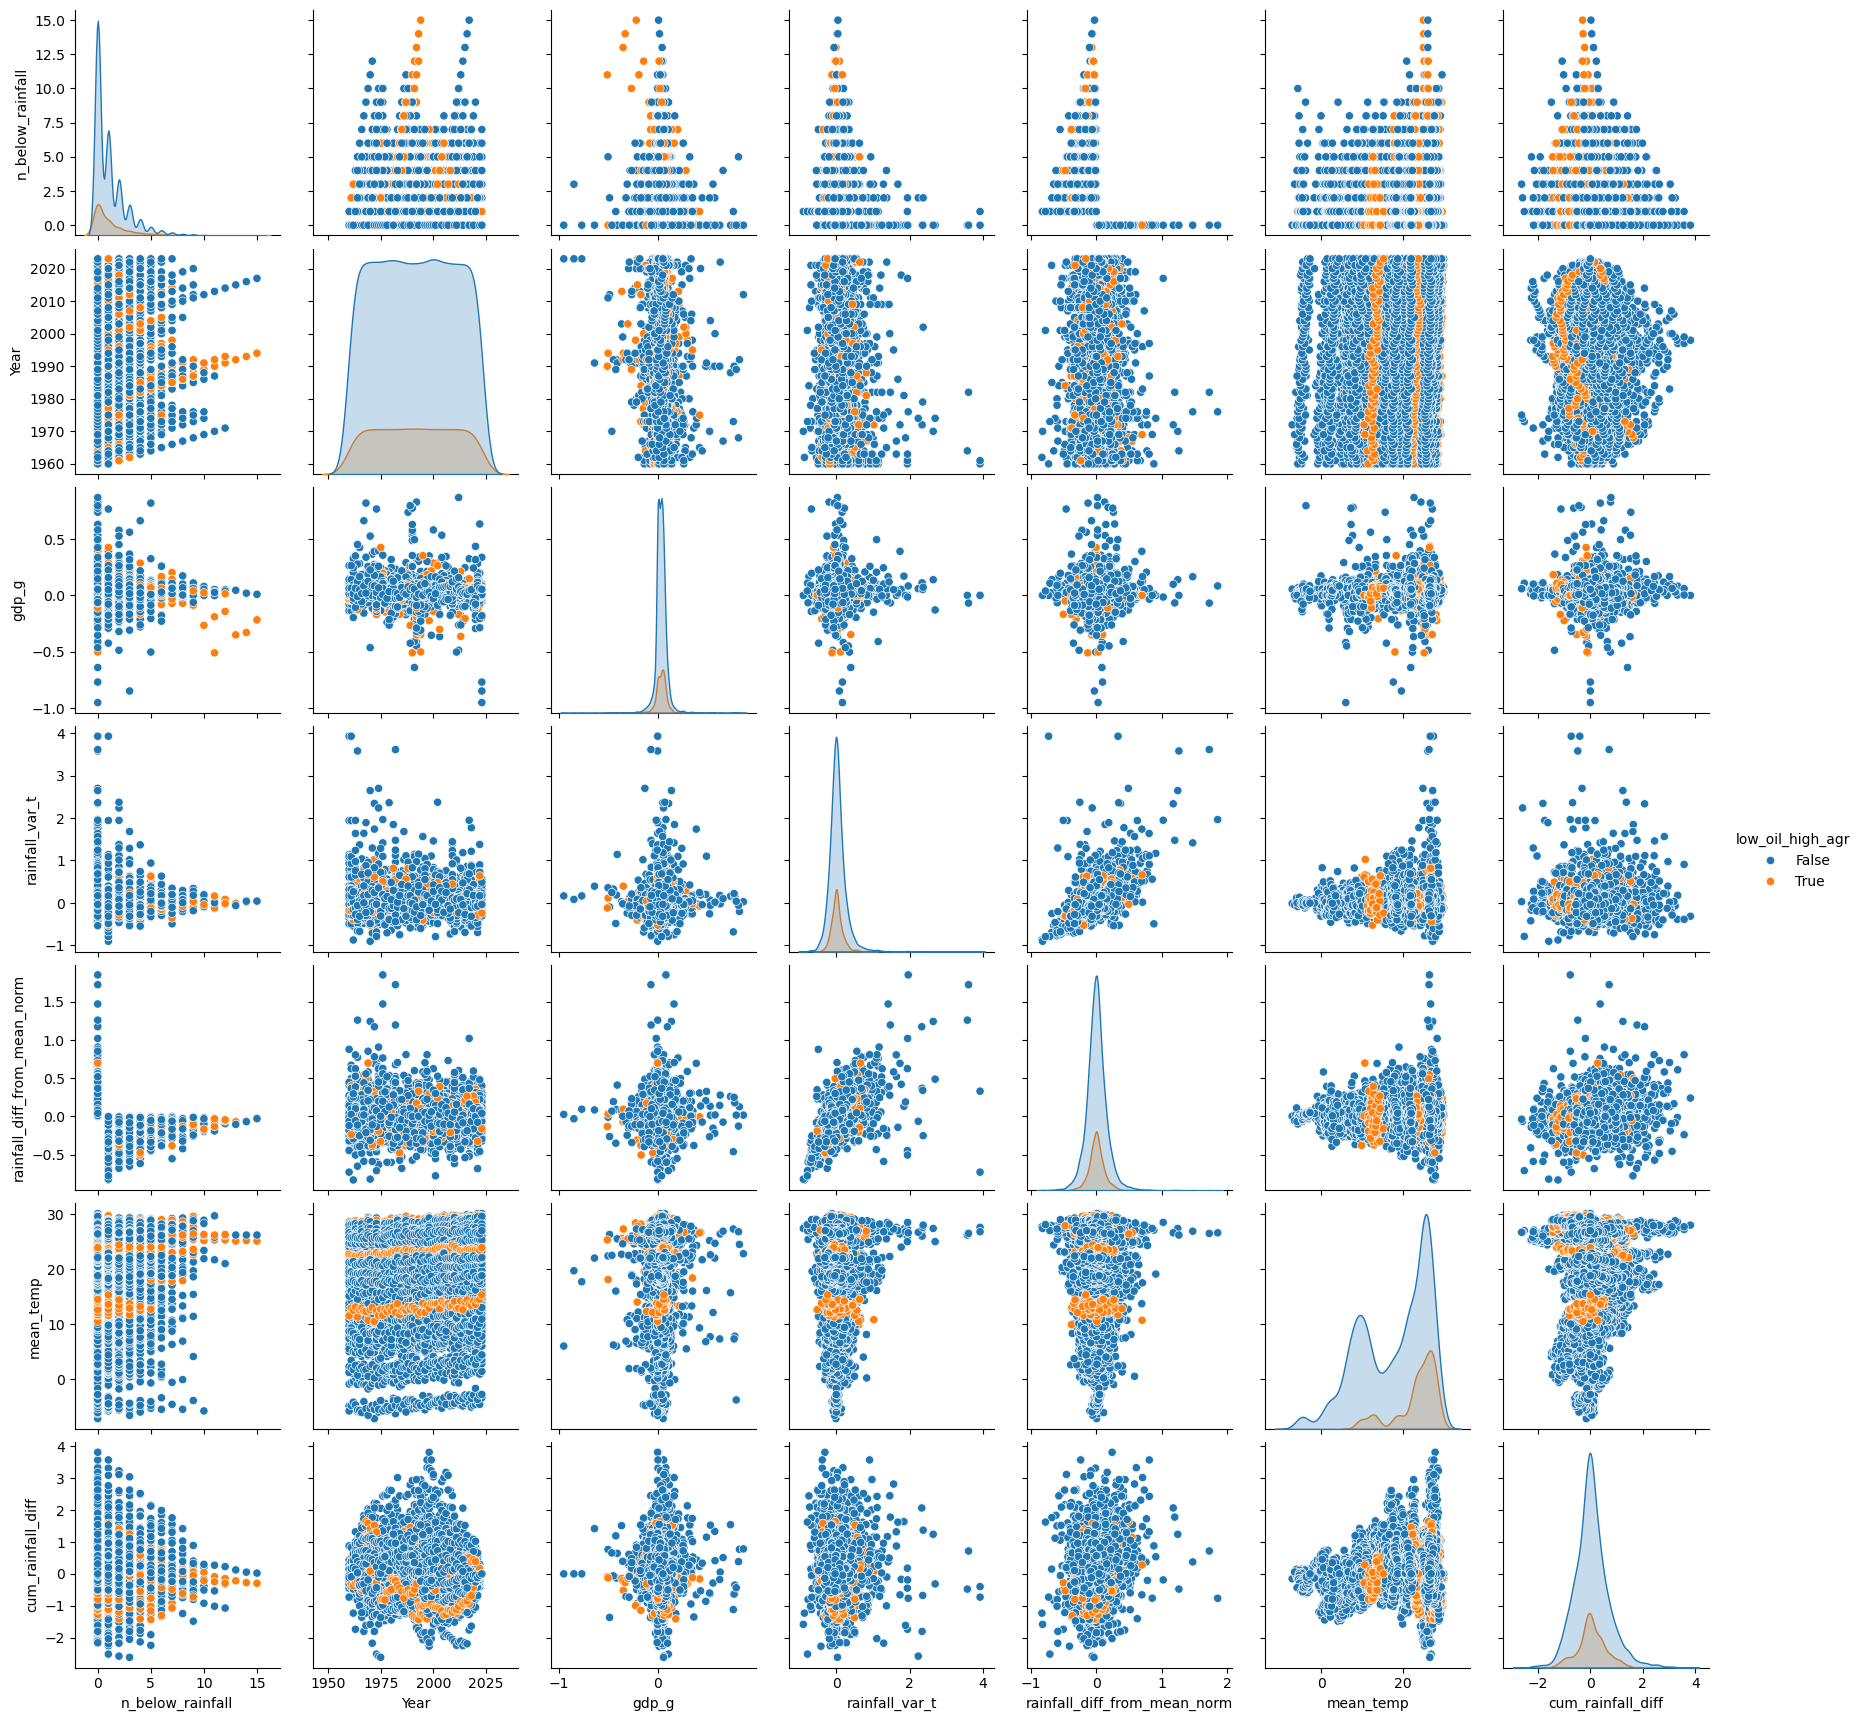

In [ ]:
plot_feats = ['n_below_rainfall', 'Year', 'gdp_g', 'rainfall_var_t', 'rainfall_diff_from_mean_norm', 'mean_temp', 'cum_rainfall_diff']
sns.pairplot(subset,
             x_vars=plot_feats,
             y_vars=plot_feats,
             hue='low_oil_high_agr')

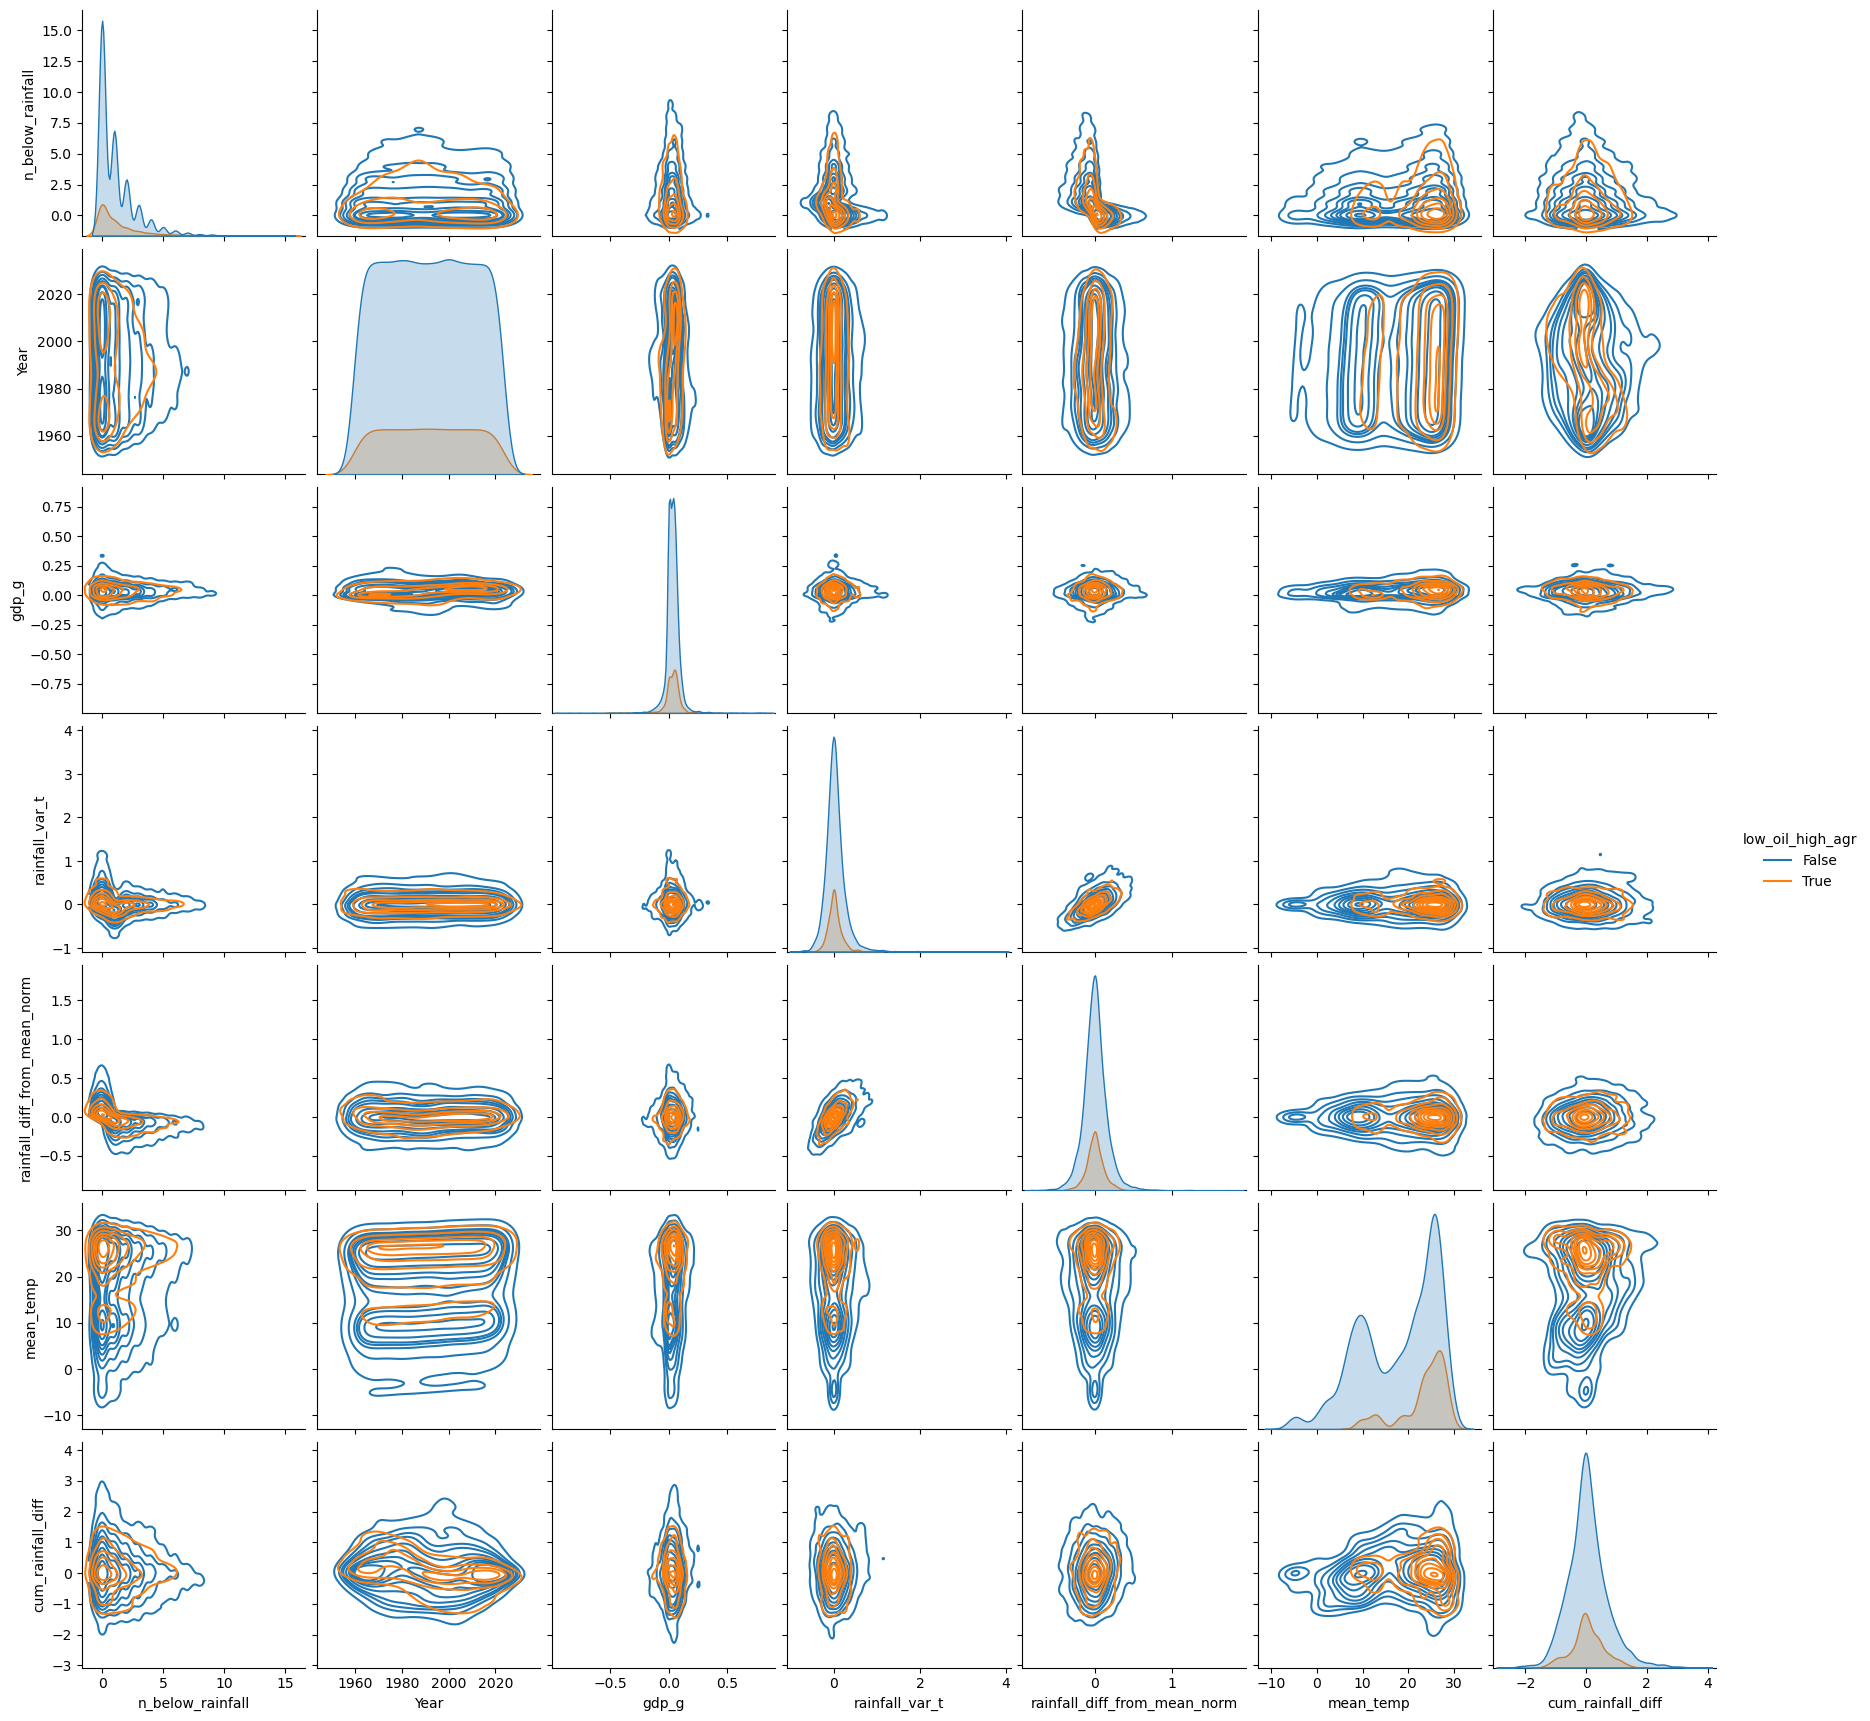

In [ ]:
plot_feats = ['n_below_rainfall', 'Year', 'gdp_g', 'rainfall_var_t', 'rainfall_diff_from_mean_norm', 'mean_temp', 'cum_rainfall_diff']
sns.pairplot(subset,
             x_vars=plot_feats,
             y_vars=plot_feats,
             hue='low_oil_high_agr',
             kind='kde')

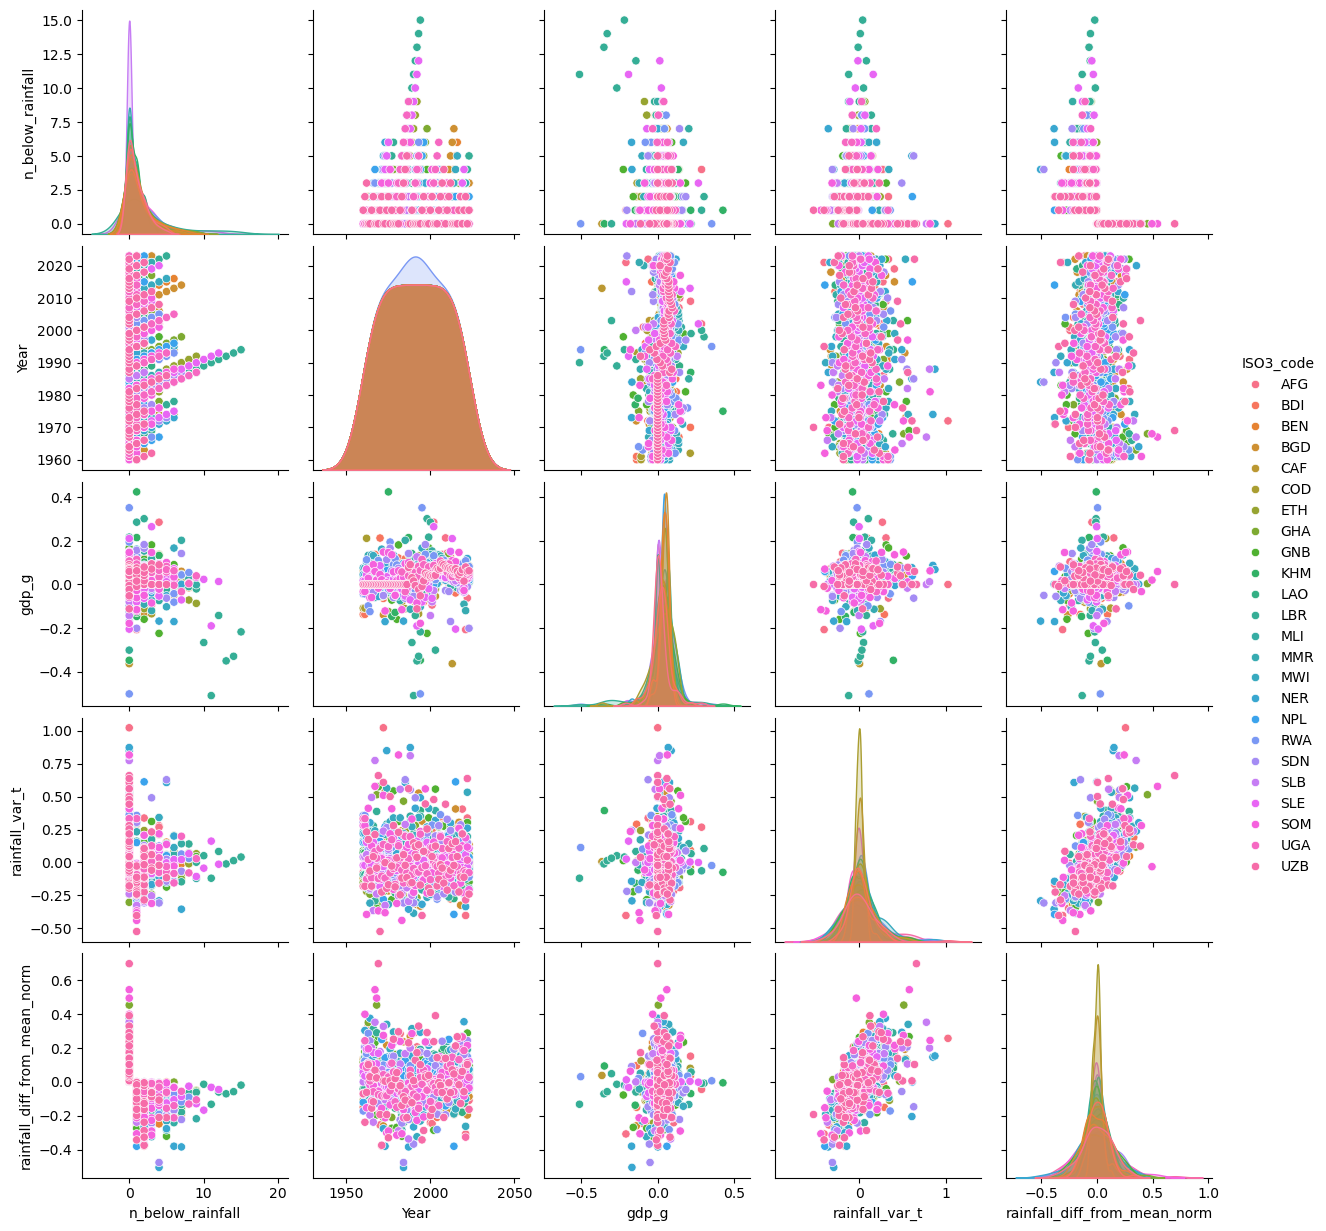

In [ ]:
plot_feats = ['n_below_rainfall', 'Year', 'gdp_g', 'rainfall_var_t', 'rainfall_diff_from_mean_norm']

sns.pairplot(subset[subset['low_oil_high_agr']==True],
             x_vars=plot_feats,
             y_vars=plot_feats,
             hue='ISO3_code')

# Save dataset to file

In [ ]:
dataset.to_csv('dataset_rainfall.csv')